this code stores the prerocessedd data into the required file


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from albumentations import Compose, GaussianBlur, RandomBrightnessContrast, Resize, Normalize
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Define paths for dataset and output directory
dataset_path = '/kaggle/input/ir-in-forestry-environments-aostovar/slu1_2014_06_24'  # Input dataset path
output_path = '/kaggle/working/preprocessed_images'  # Directory to save preprocessed images

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Preprocessing pipeline
def preprocess_image(image):
    transform = Compose([
        GaussianBlur(blur_limit=(3, 7), p=0.5),            # Denoising using Gaussian blur
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # Augmentation
        Resize(224, 224),                                   # Resizing for Swin Transformer input size
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # Normalization for Swin Transformer
    ])
    return transform(image=image)['image']

def load_and_preprocess_images(dataset_path, limit=100):
    images = []
    preprocessed_images = []
    titles = []

    # List files in the dataset directory
    for i, filename in enumerate(os.listdir(dataset_path)):
        if i >= limit:  # Limit to the first 'limit' images
            break
        img_path = os.path.join(dataset_path, filename)
        image = cv2.imread(img_path)

        if image is not None:
            images.append(image)
            processed_image = preprocess_image(image)
            preprocessed_images.append(processed_image)
            titles.append(filename)

            # Save the preprocessed image to the output path
            processed_image_path = os.path.join(output_path, f"processed_{filename}")
            cv2.imwrite(processed_image_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))  # Convert to BGR for saving

    return images, preprocessed_images, titles

# Calculate PSNR and SSIM
def calculate_metrics(original, processed):
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    processed_gray = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)

    # PSNR
    psnr_value = psnr(original, processed, data_range=processed.max() - processed.min())
    
    # SSIM
    ssim_value = ssim(original_gray, processed_gray, data_range=processed_gray.max() - processed_gray.min())
    
    return psnr_value, ssim_value

def analyze_images(images, preprocessed_images, titles):
    psnr_values = []
    ssim_values = []
    
    for i in range(len(images)):
        psnr_value, ssim_value = calculate_metrics(images[i], preprocessed_images[i])
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
        print(f"Image: {titles[i]}, PSNR: {psnr_value:.2f} dB, SSIM: {ssim_value:.4f}")

    return psnr_values, ssim_values

# Plot pixel intensity distribution
def plot_pixel_intensity(original, processed, title):
    original_intensity = original.flatten()
    processed_intensity = processed.flatten()
    
    plt.figure(figsize=(10, 5))
    plt.hist(original_intensity, bins=50, color='blue', alpha=0.6, label='Original')
    plt.hist(processed_intensity, bins=50, color='orange', alpha=0.6, label='Preprocessed')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(f'Pixel Intensity Distribution for {title}')
    plt.legend()
    plt.show()

def visualize_comparison(images, preprocessed_images, titles):
    num_images = len(images)

    plt.figure(figsize=(15, num_images * 5))  # Adjust size to fit the number of images

    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 2, i * 2 + 1)  # First column for original images
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Original {titles[i]}')
        plt.axis('off')

        # Preprocessed Image
        plt.subplot(num_images, 2, i * 2 + 2)  # Second column for preprocessed images
        plt.imshow(cv2.cvtColor(preprocessed_images[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Processed {titles[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load and preprocess images
    images, preprocessed_images, titles = load_and_preprocess_images(dataset_path, limit=100)
    
    # Visualize original and preprocessed images
    #visualize_comparison(images, preprocessed_images, titles)
    
    # Analyze PSNR and SSIM for each image
    psnr_values, ssim_values = analyze_images(images, preprocessed_images, titles)
    
    # Plot pixel intensity distribution for each image pair
    for i in range(len(images)):
        plot_pixel_intensity(images[i], preprocessed_images[i], titles[i])


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


ValueError: Input images must have the same dimensions.

code below is for storing the images seperately into rgb, thermal, infra but  not needed if we are inputing the  three modalities in a single file


In [ ]:
import os

# Define main output directory and subdirectories for each modality
output_dir = '/kaggle/working/processed_images'
rgb_dir = os.path.join(output_dir, 'RGB')
thermal_dir = os.path.join(output_dir, 'Thermal')
infrared_dir = os.path.join(output_dir, 'Infrared')

# Create directories if they don't exist
os.makedirs(rgb_dir, exist_ok=True)
os.makedirs(thermal_dir, exist_ok=True)
os.makedirs(infrared_dir, exist_ok=True)

def save_preprocessed_image(processed_image, filename, modality):
    if modality == 'RGB':
        save_path = os.path.join(rgb_dir, filename)
    elif modality == 'Thermal':
        save_path = os.path.join(thermal_dir, filename)
    elif modality == 'Infrared':
        save_path = os.path.join(infrared_dir, filename)
    else:
        raise ValueError("Unknown modality type.")

    # Save the processed image in the corresponding folder
    cv2.imwrite(save_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))  # Convert back to BGR for OpenCV


thermalImageGrey311.jpg - PSNR: -40.40, SSIM: 0.0001
fusedImage164.jpg - PSNR: -35.28, SSIM: -0.0001
optrisImage222.jpg - PSNR: -37.21, SSIM: -0.0000
thermalImage165.jpg - PSNR: -31.77, SSIM: -0.0928
fusedImage431.jpg - PSNR: -35.96, SSIM: 0.0000
thermalImageGrey248.jpg - PSNR: -41.08, SSIM: 0.0000
thermalImageGrey37.jpg - PSNR: -41.39, SSIM: -0.0000
thermalImage273.jpg - PSNR: -33.21, SSIM: -0.1307
fusedImage452.jpg - PSNR: -35.38, SSIM: -0.0001
optrisImage50.jpg - PSNR: -36.94, SSIM: 0.0000
thermalImageGrey390.jpg - PSNR: -39.00, SSIM: 0.0000
optrisImage137.jpg - PSNR: -37.20, SSIM: -0.0000
fusedImage94.jpg - PSNR: -34.86, SSIM: -0.0002
fusedImage268.jpg - PSNR: -35.17, SSIM: -0.0001
optrisImage144.jpg - PSNR: -38.32, SSIM: 0.0001
fusedImage462.jpg - PSNR: -35.19, SSIM: -0.0001
thermalImage99.jpg - PSNR: -31.19, SSIM: -0.1259
optrisImage370.jpg - PSNR: -38.57, SSIM: -0.0000
optrisImage76.jpg - PSNR: -37.00, SSIM: -0.0000
thermalImageGrey84.jpg - PSNR: -38.69, SSIM: 0.0000
optrisImage

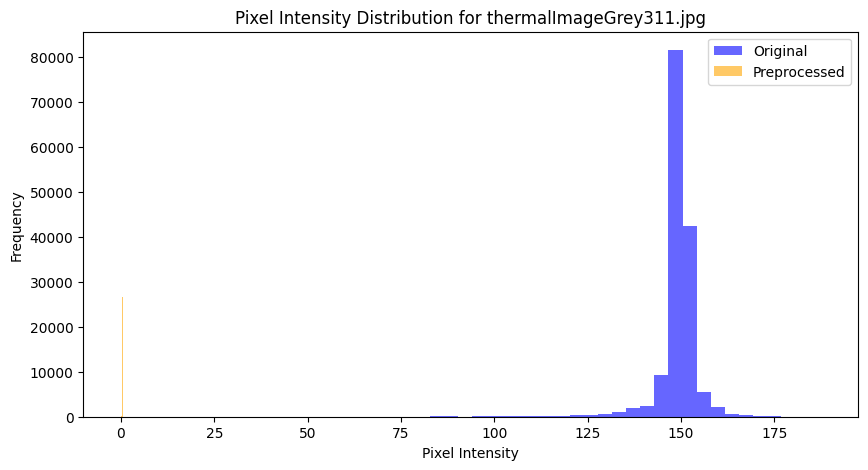

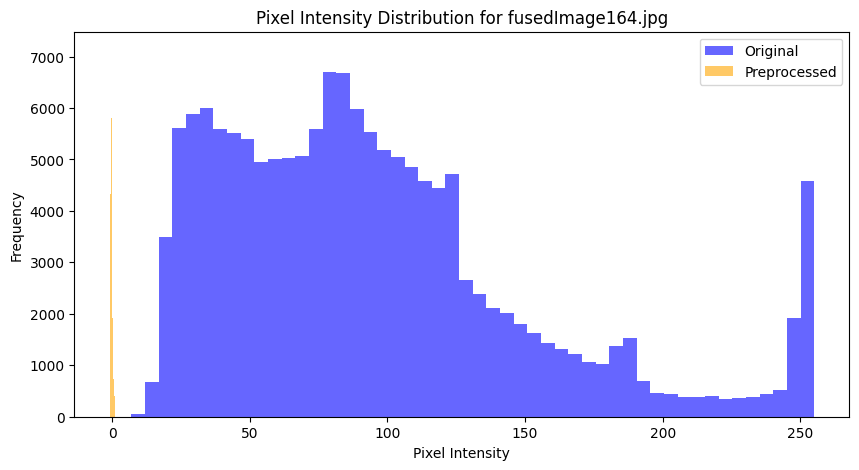

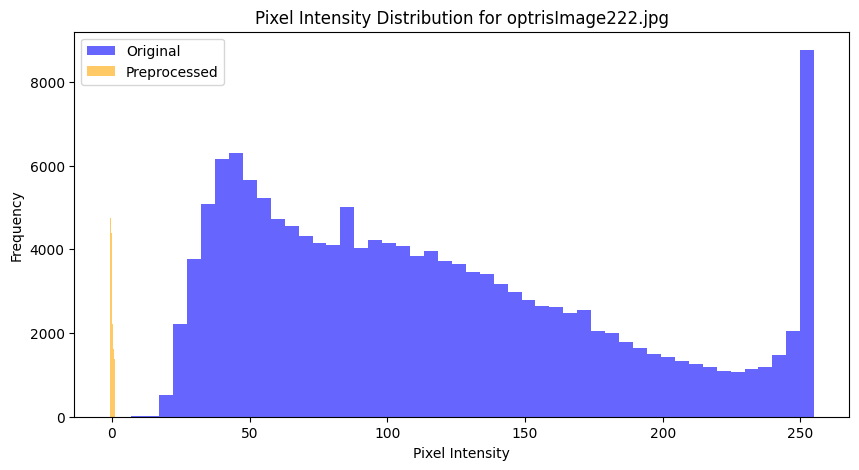

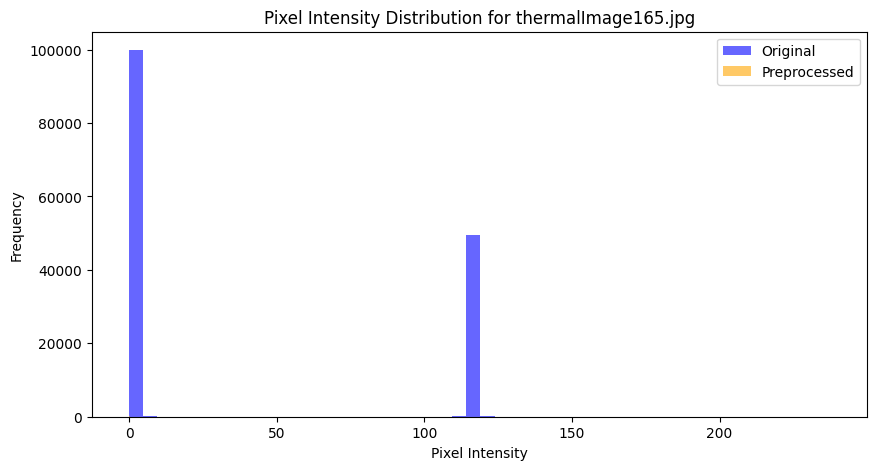

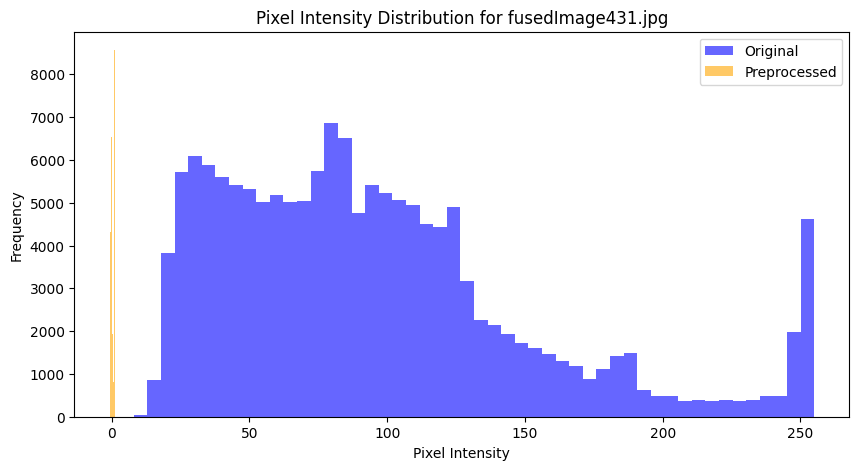

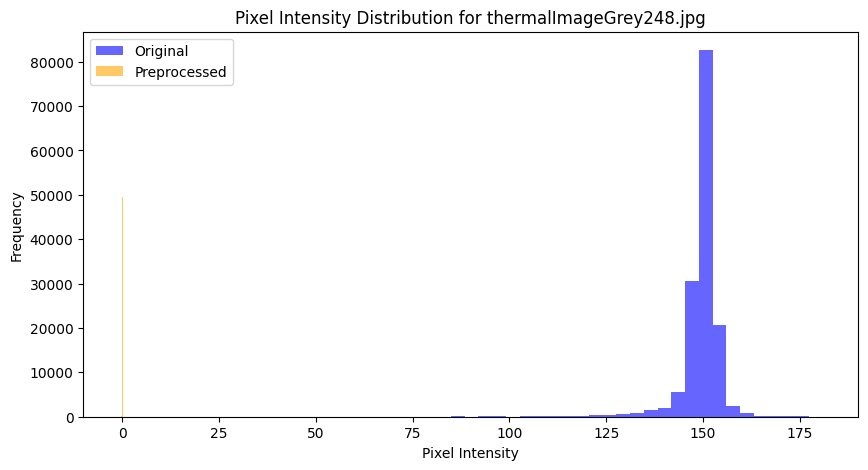

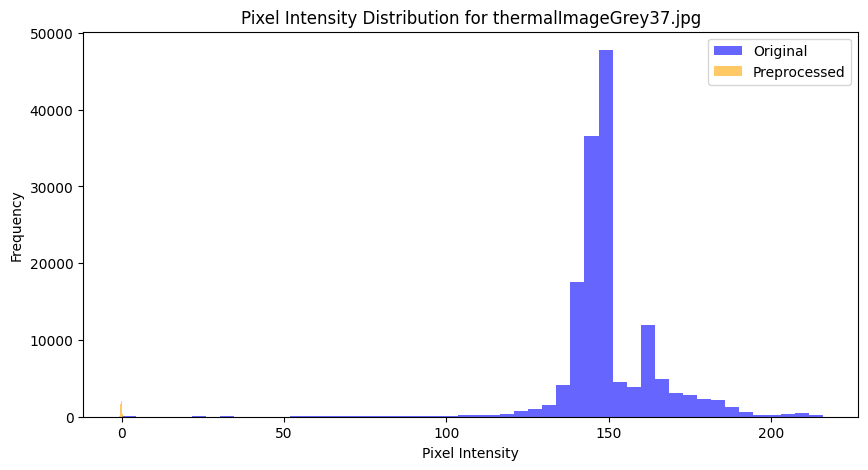

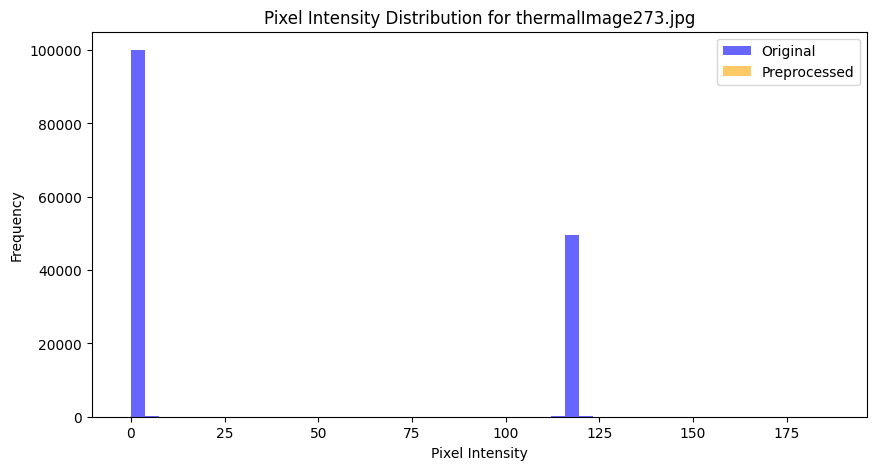

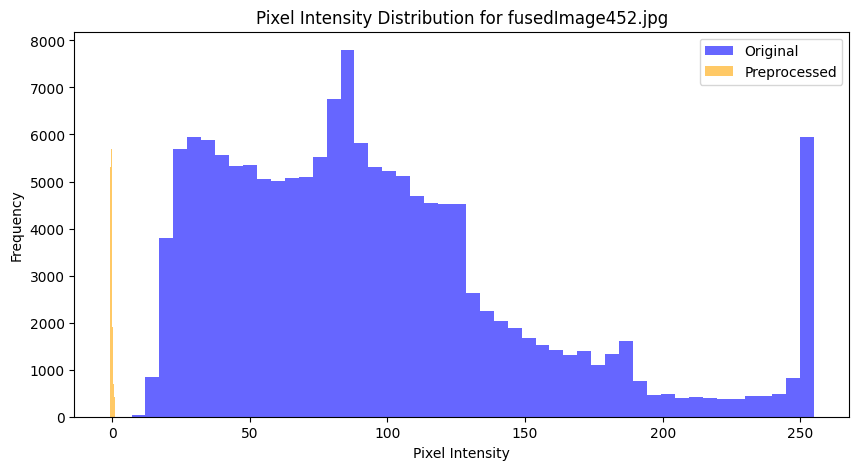

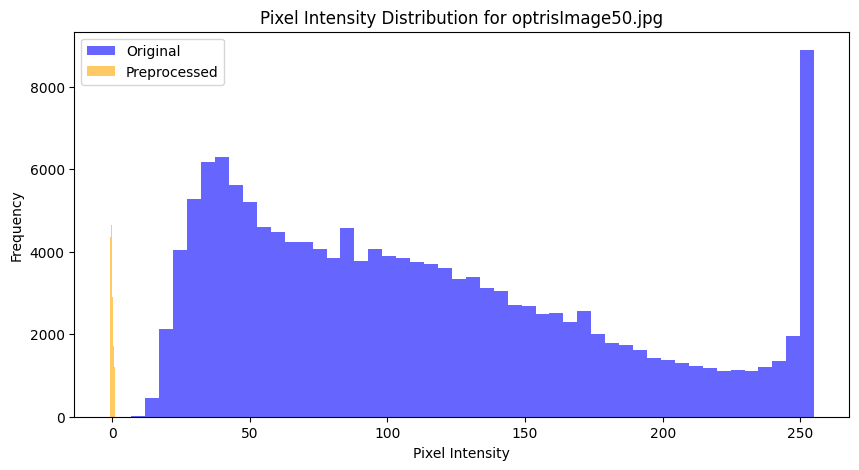

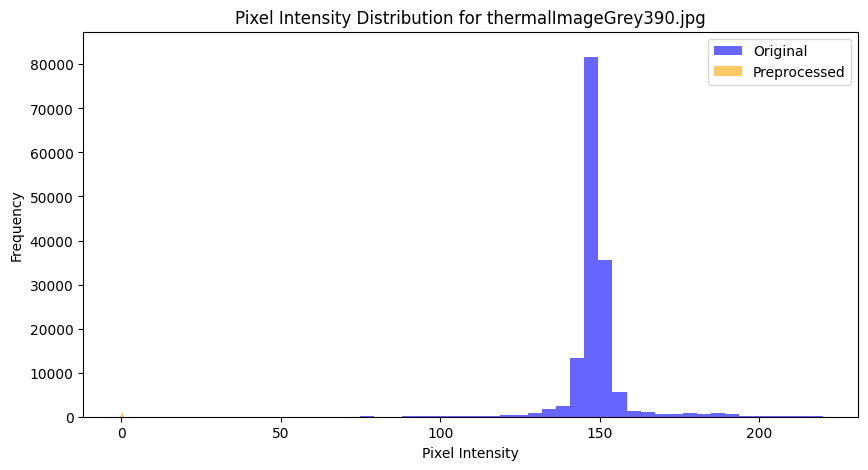

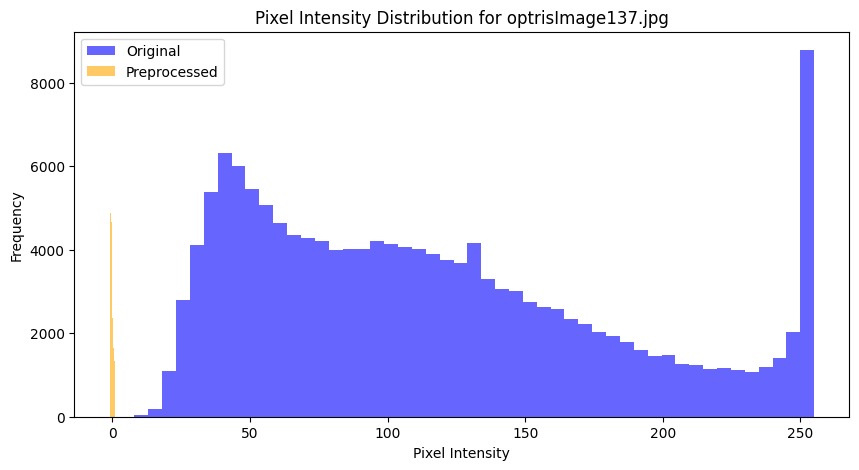

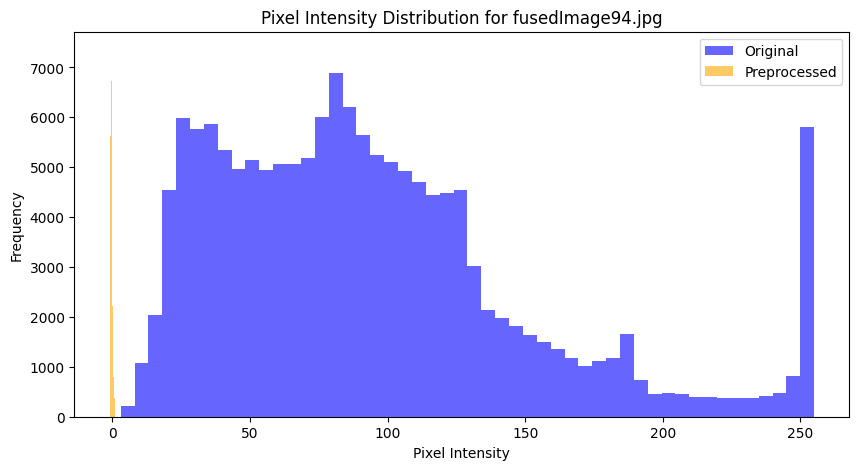

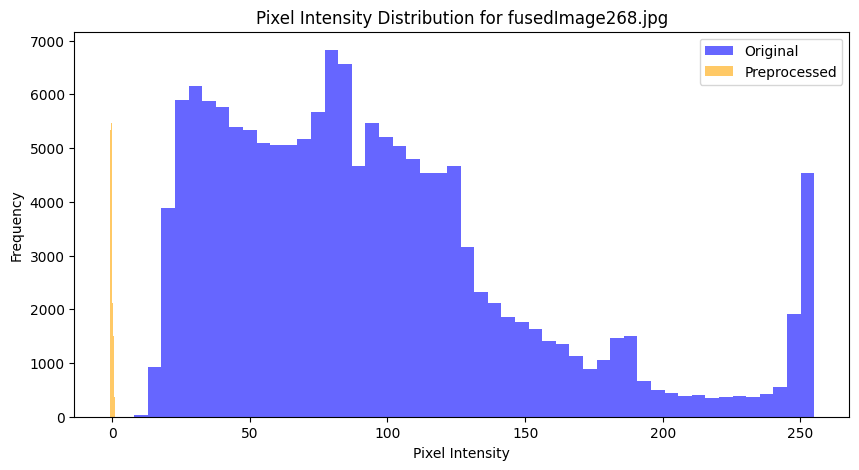

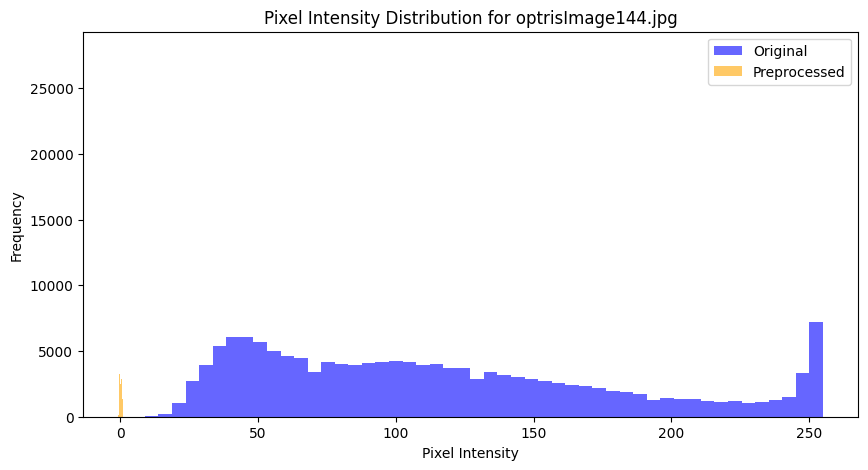

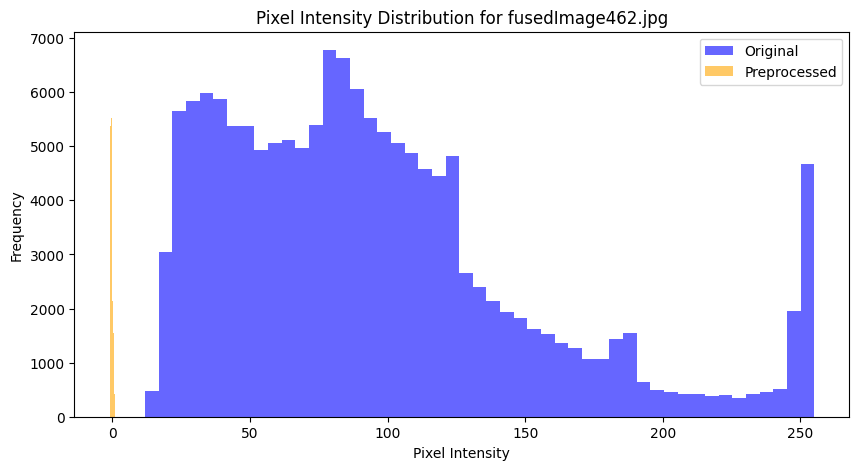

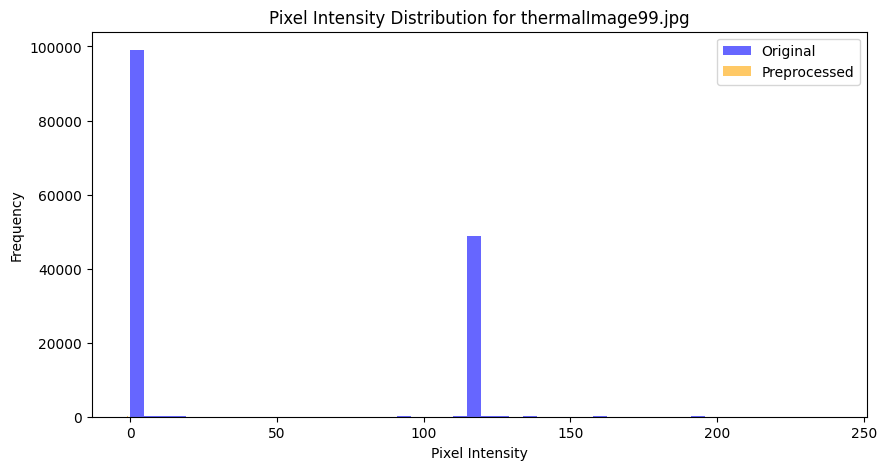

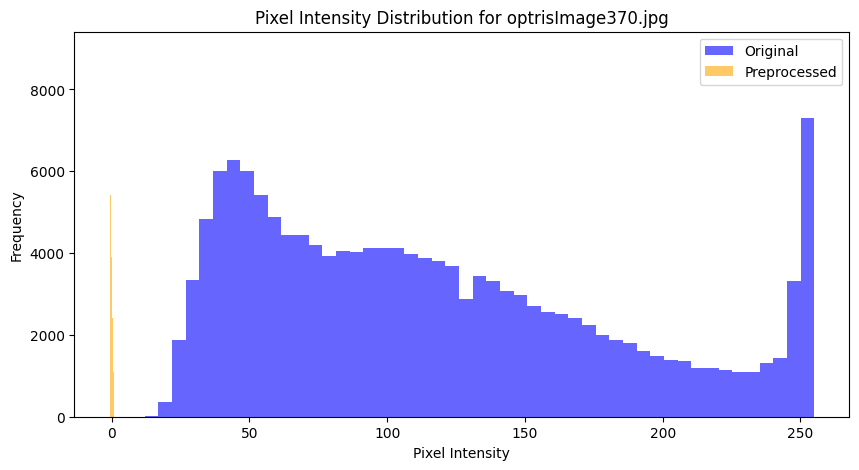

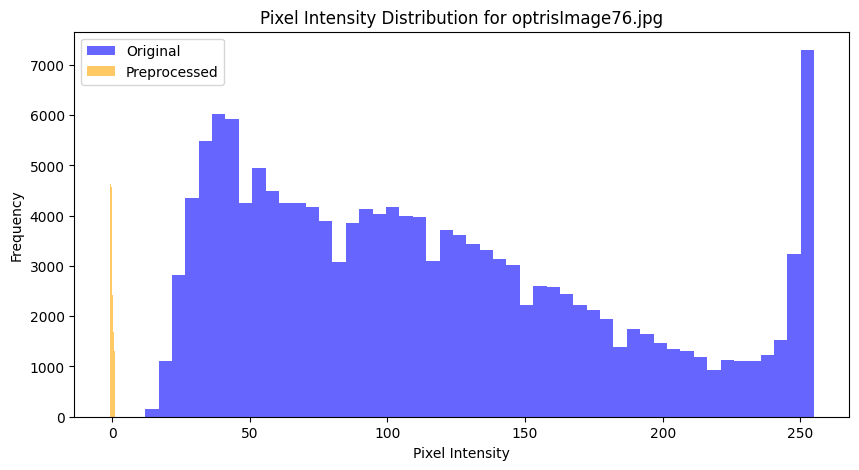

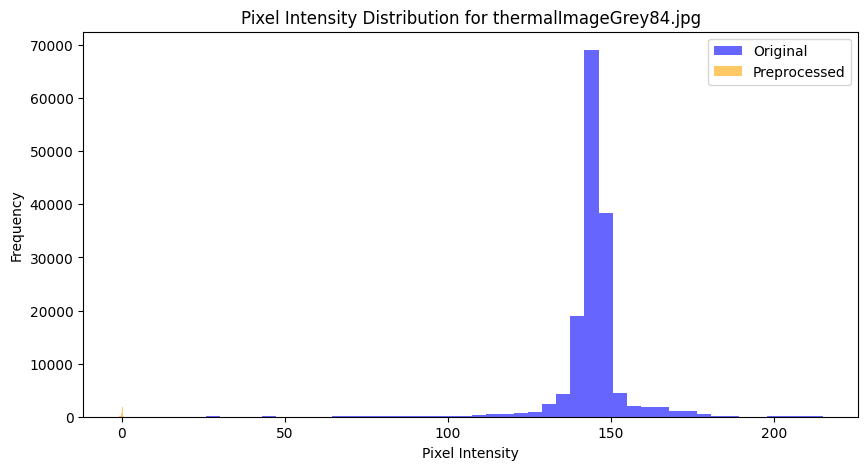

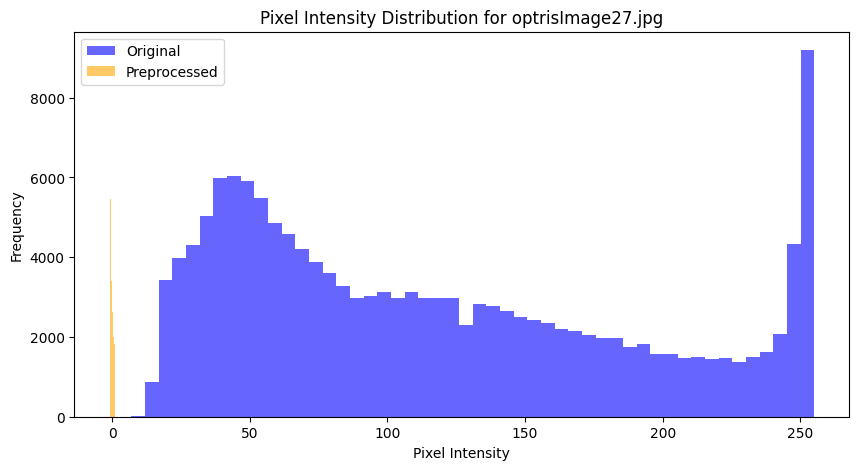

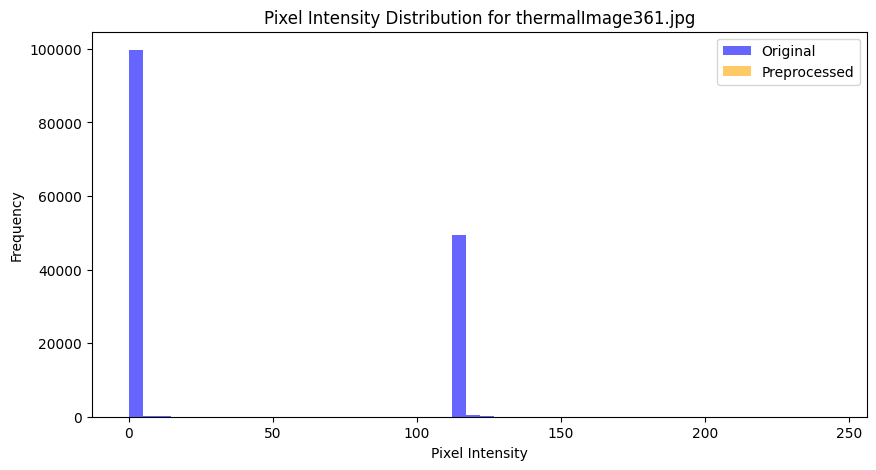

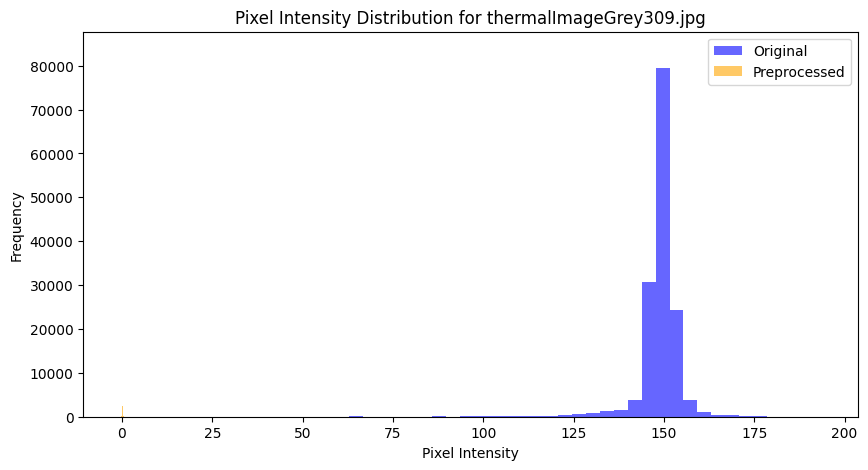

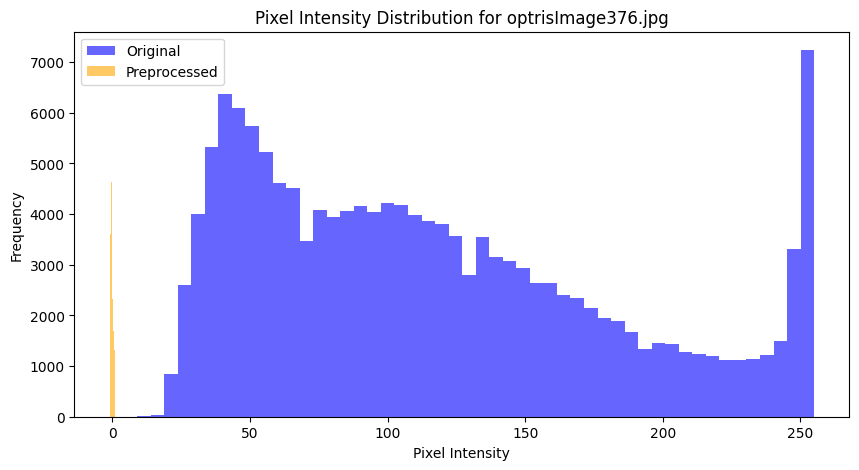

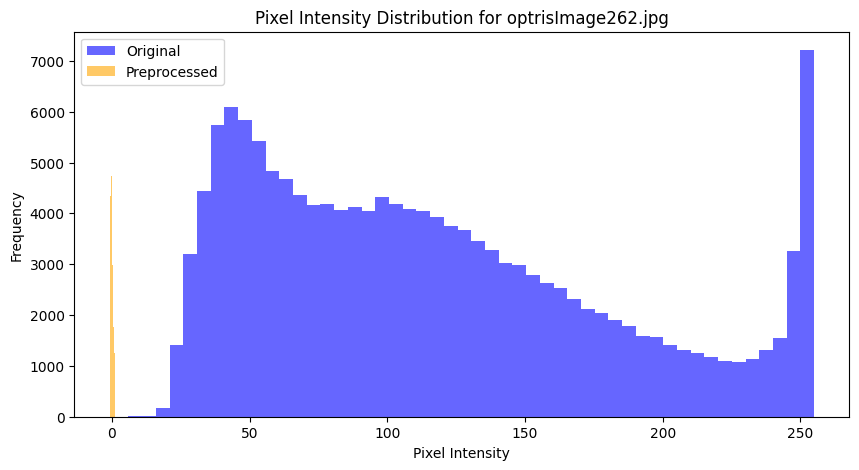

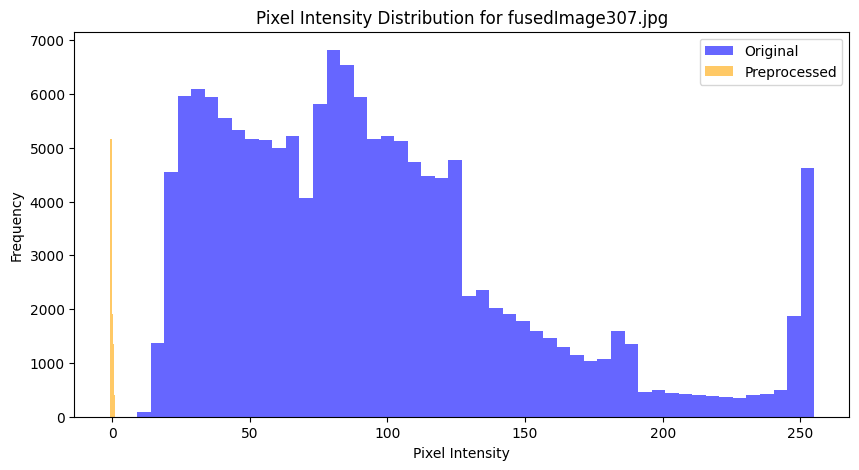

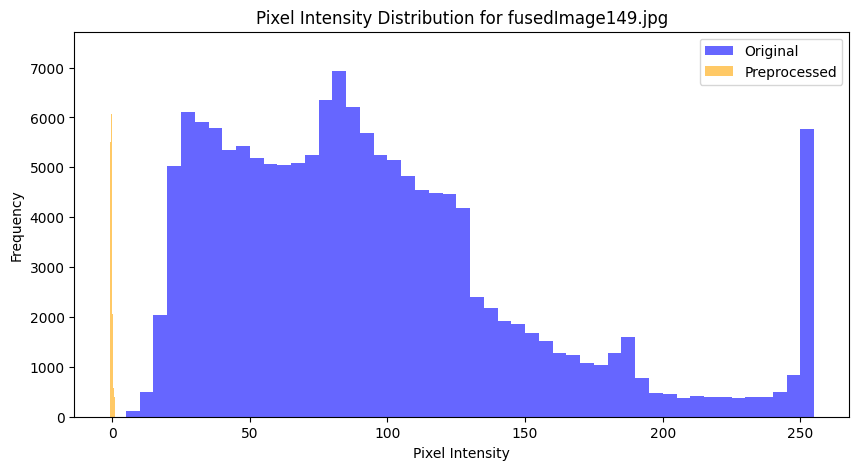

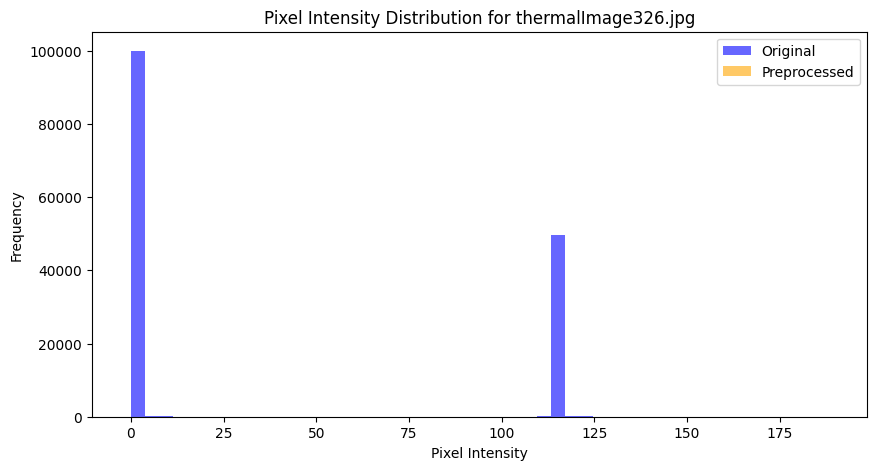

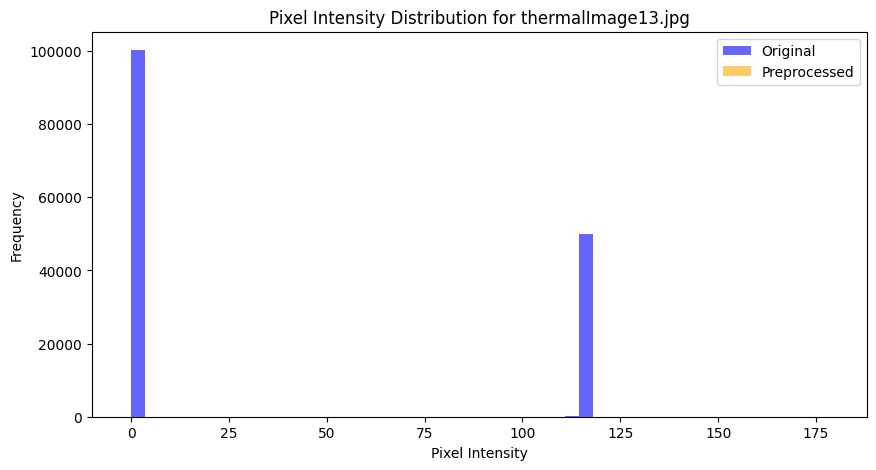

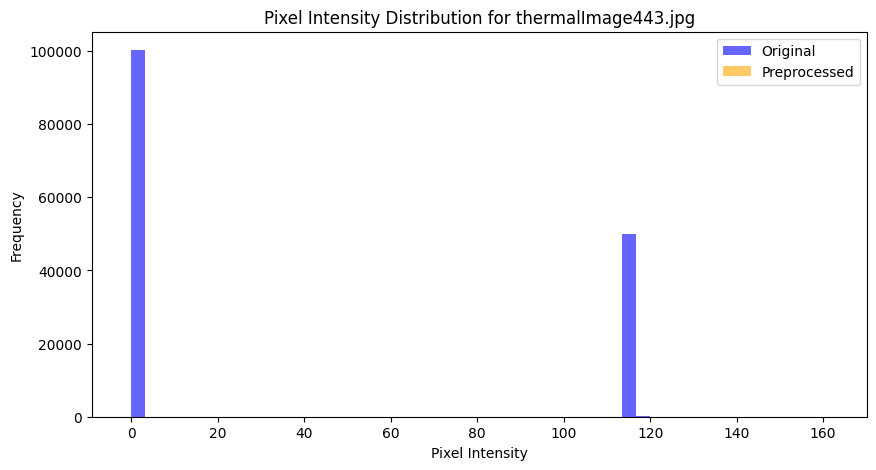

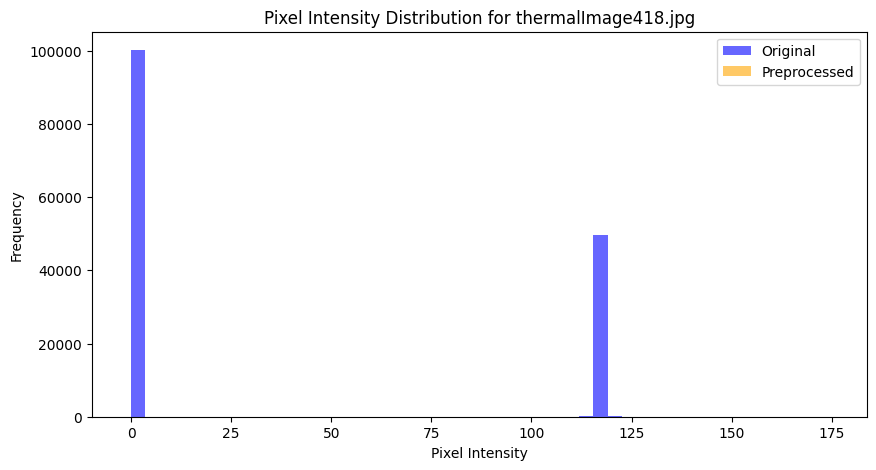

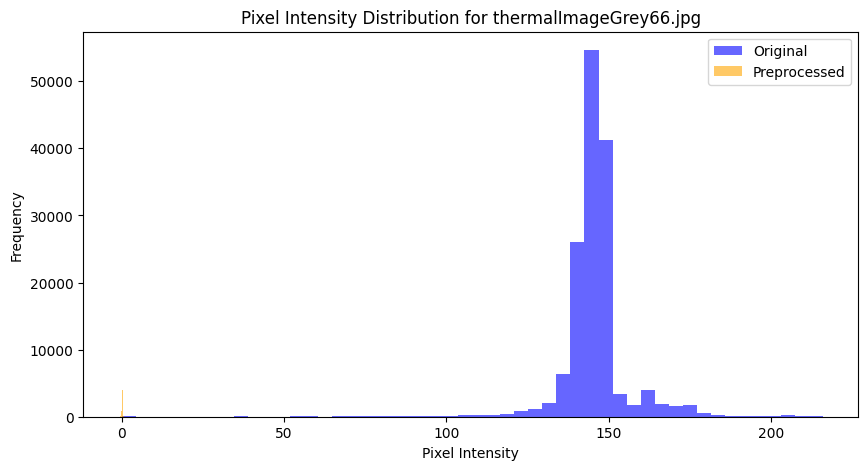

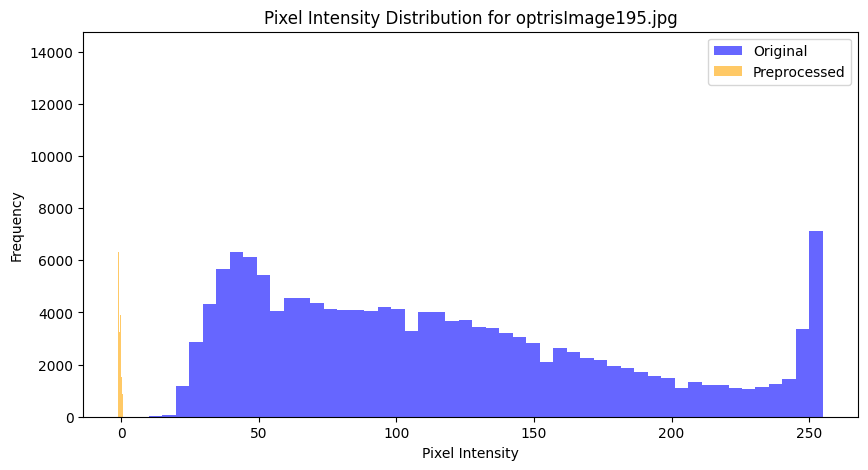

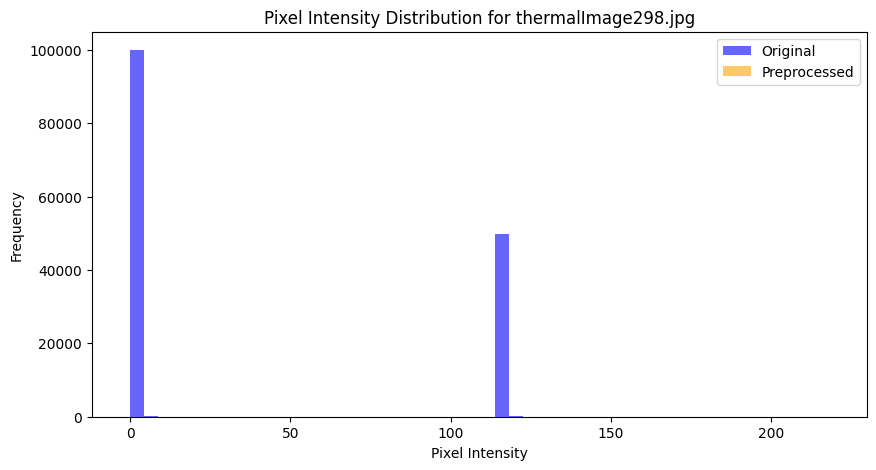

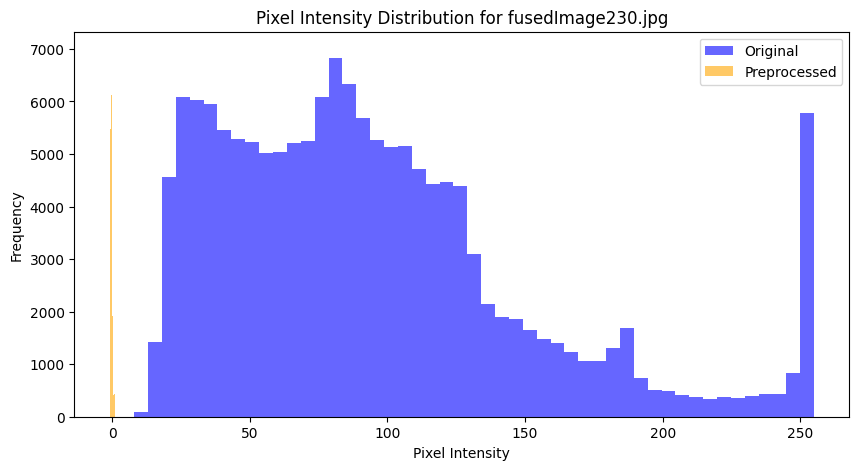

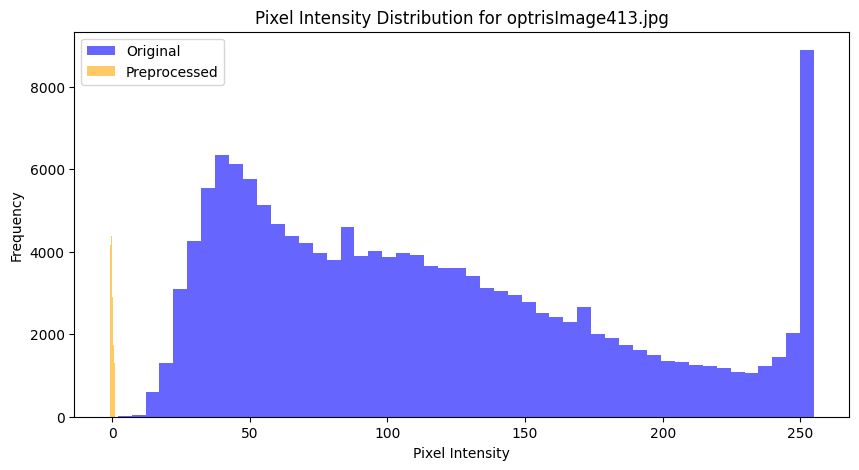

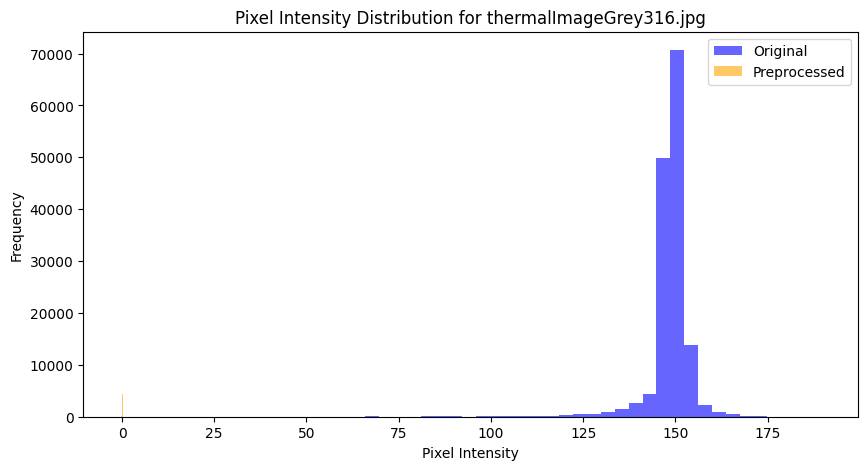

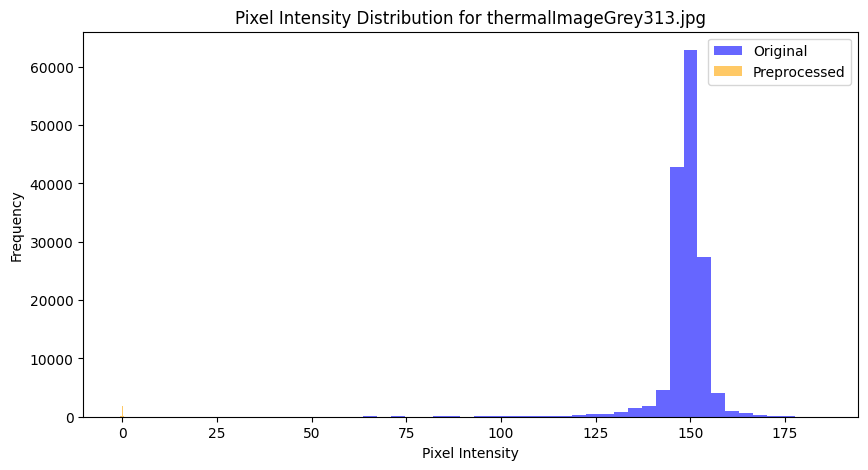

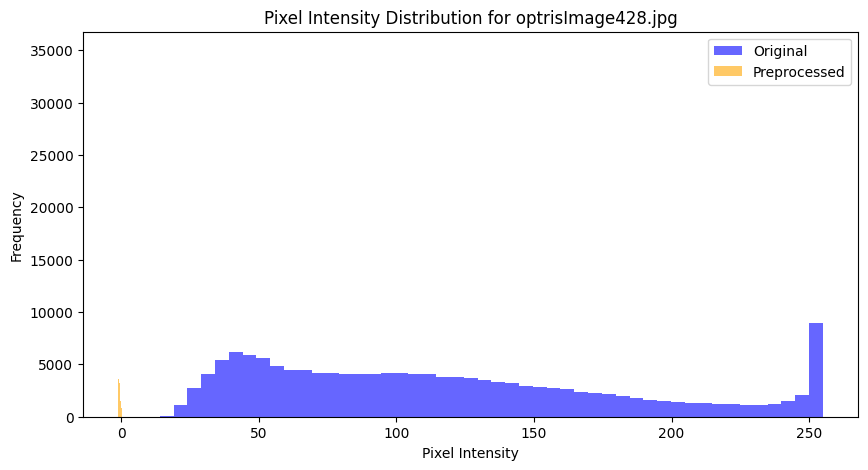

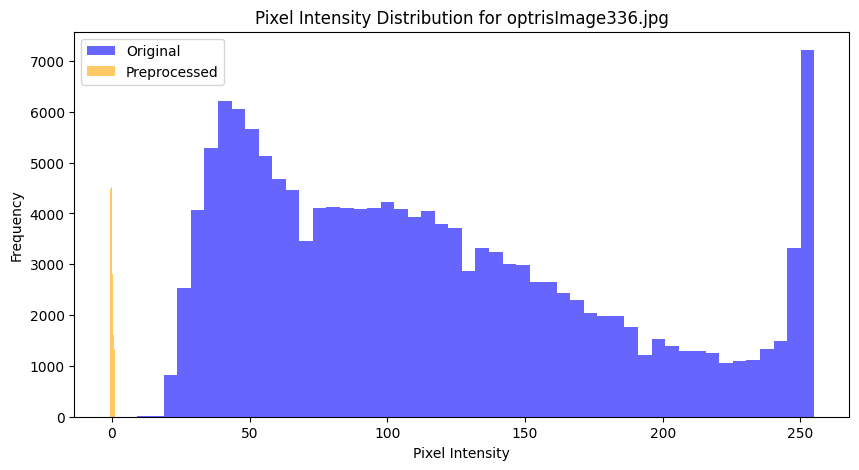

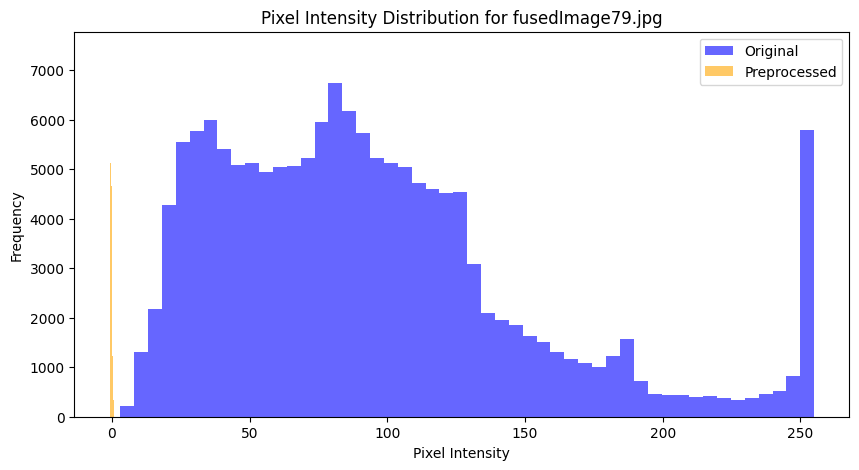

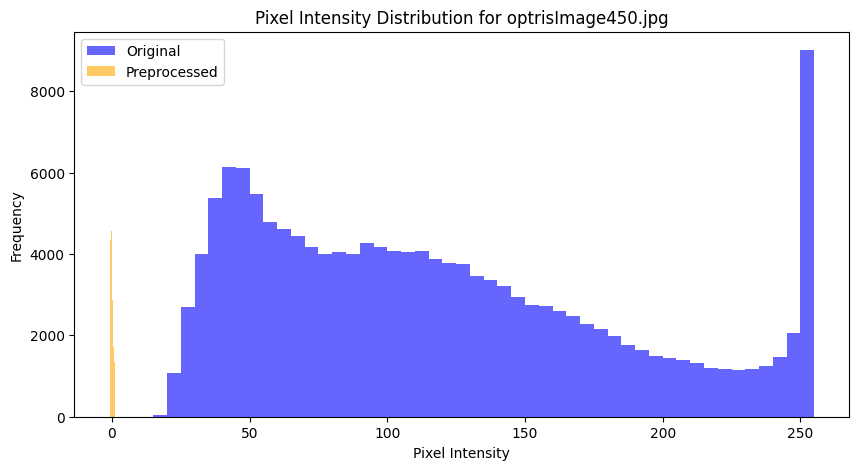

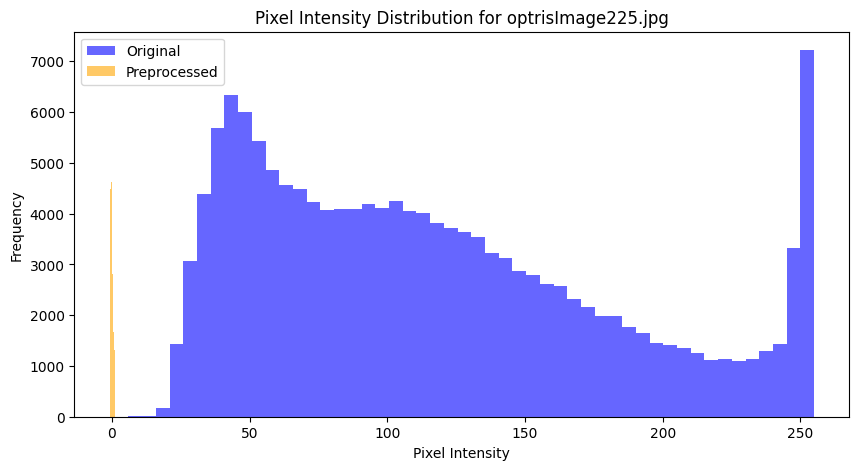

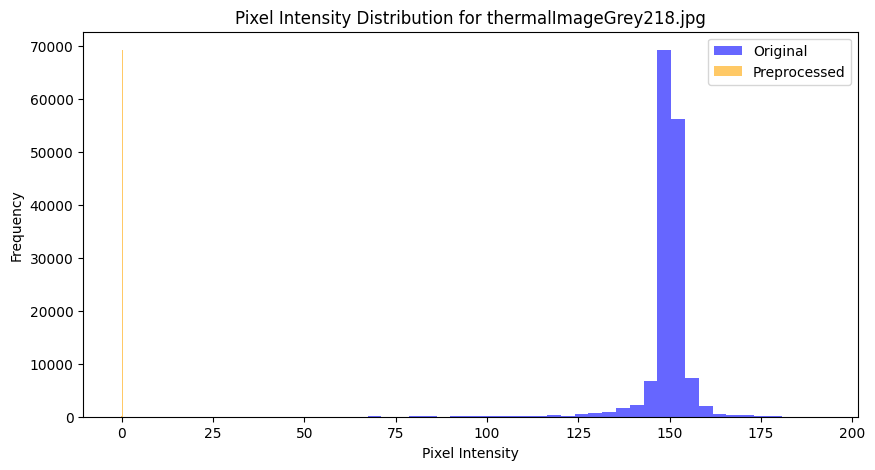

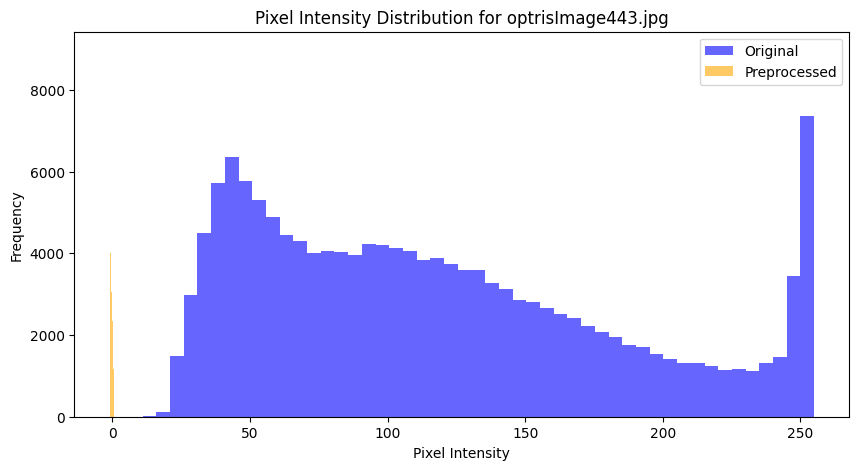

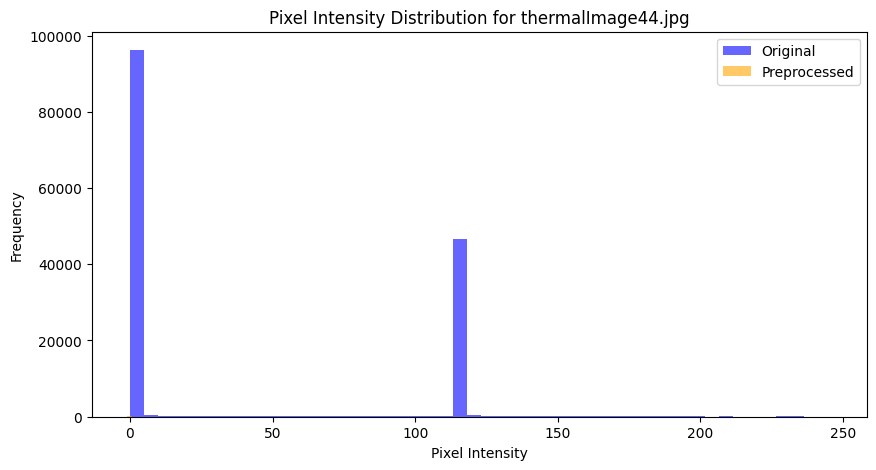

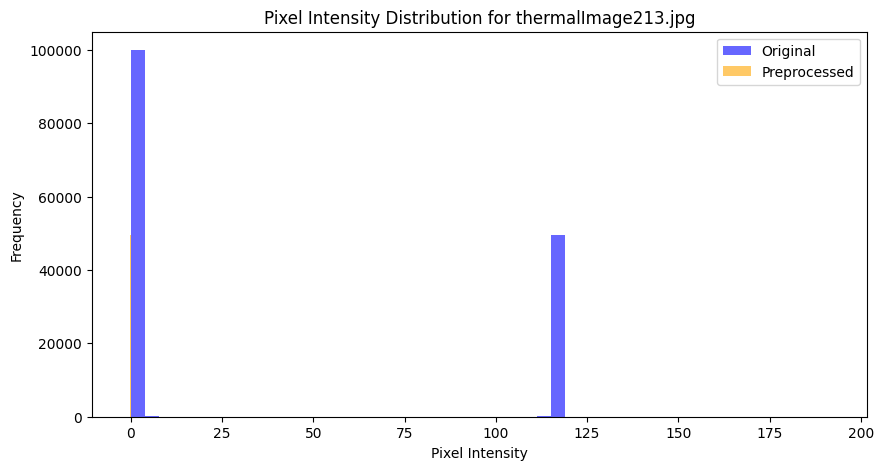

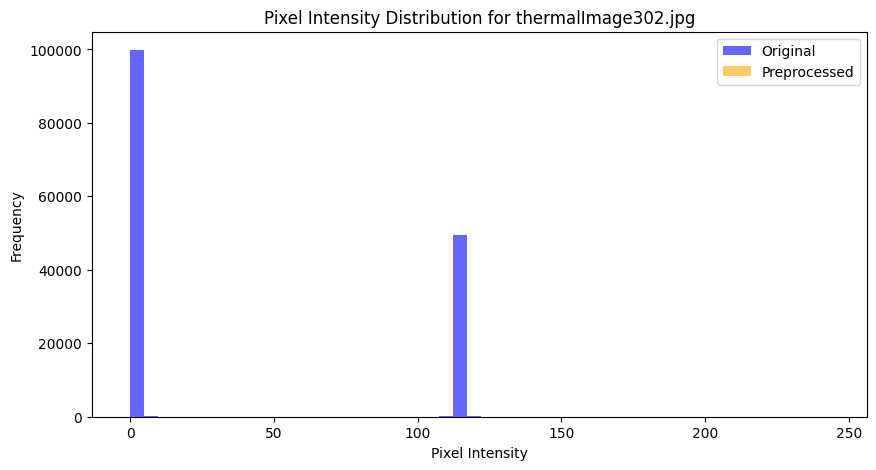

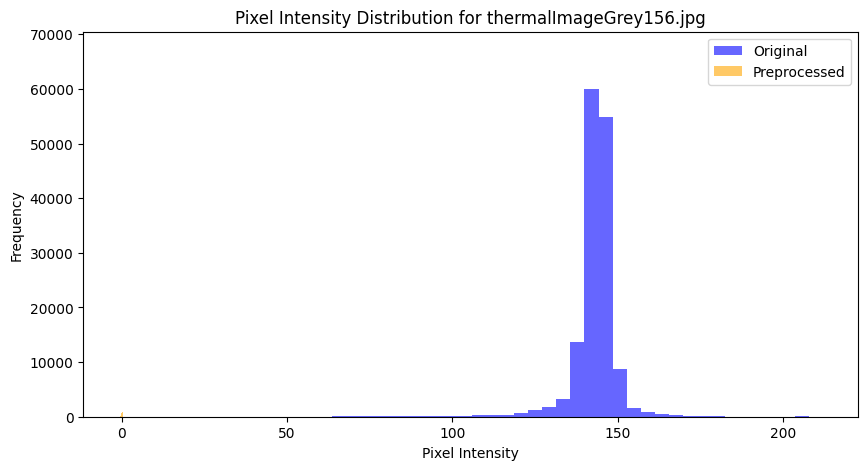

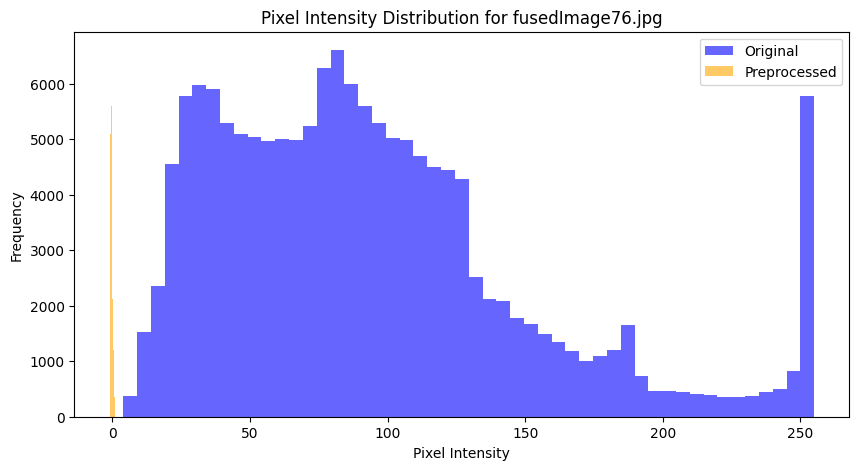

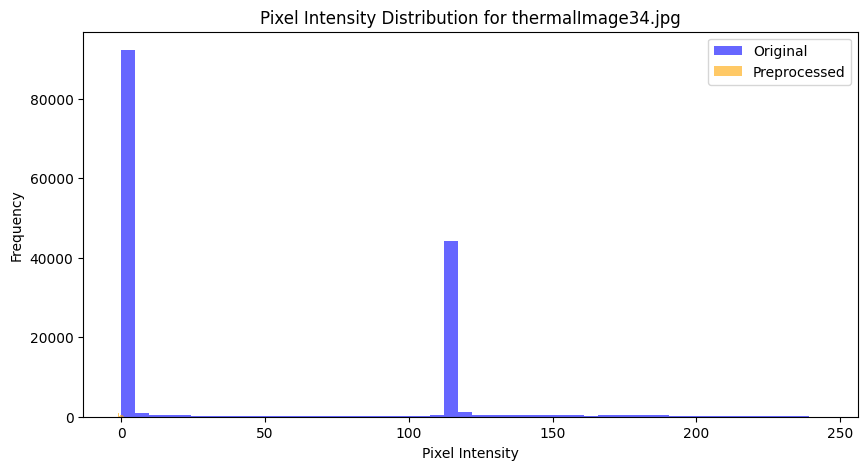

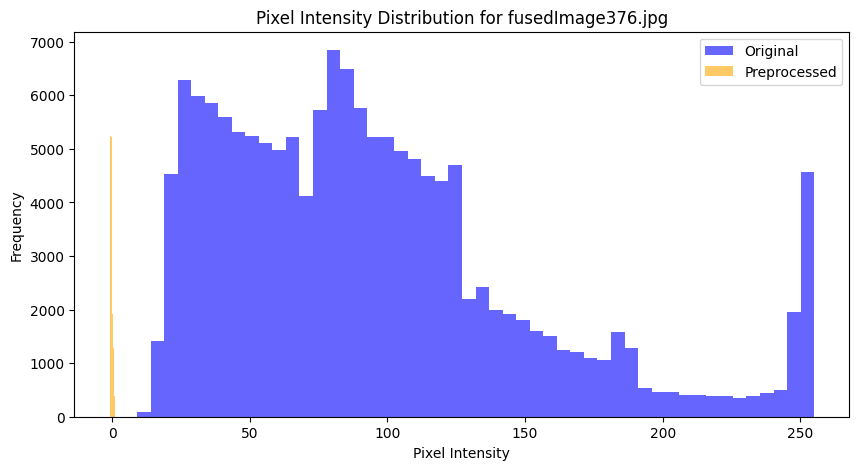

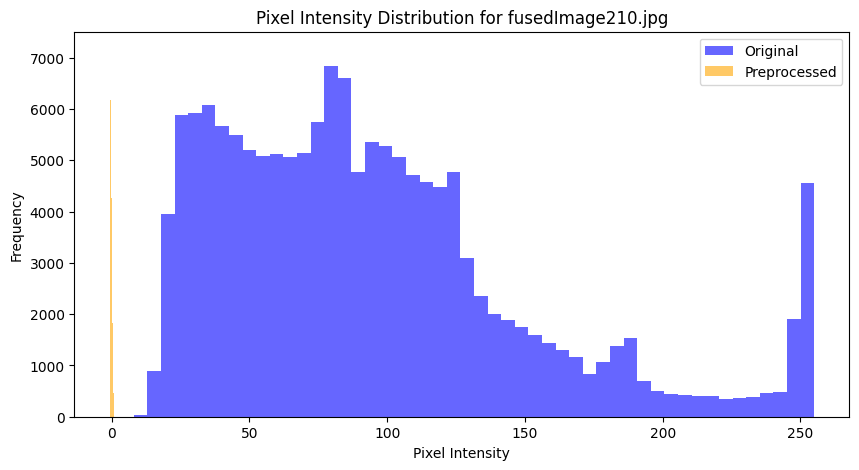

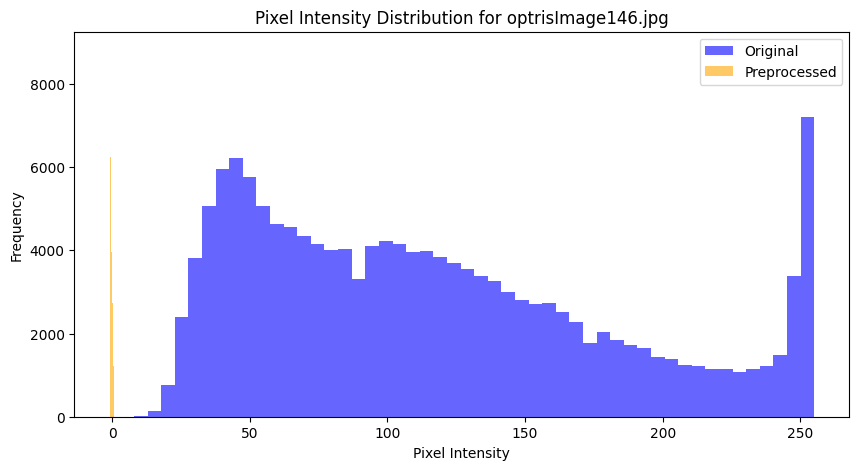

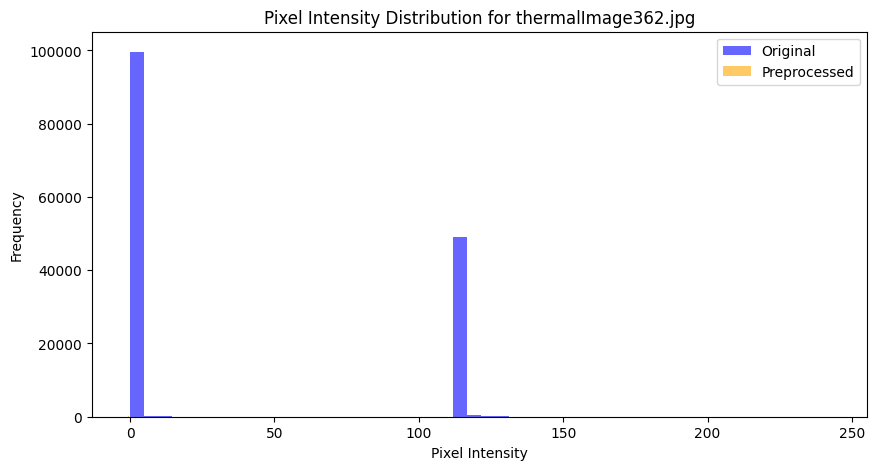

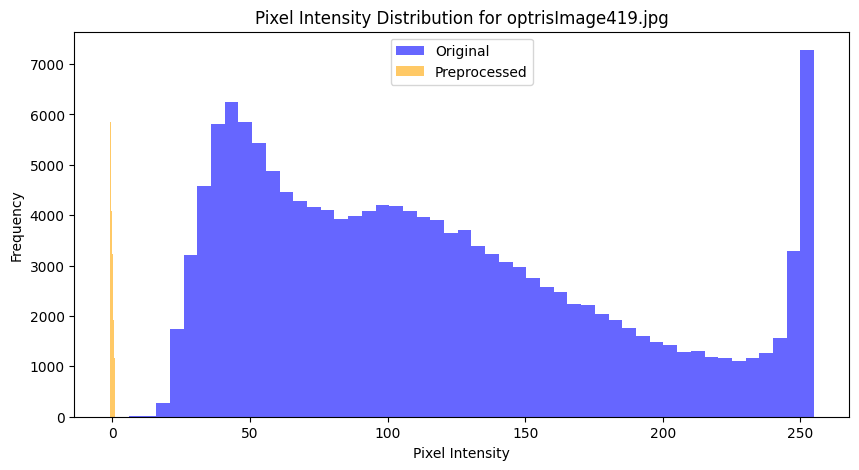

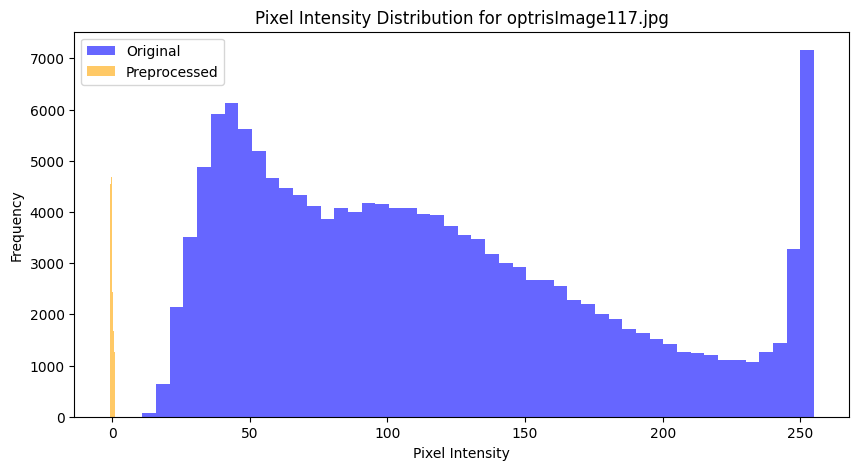

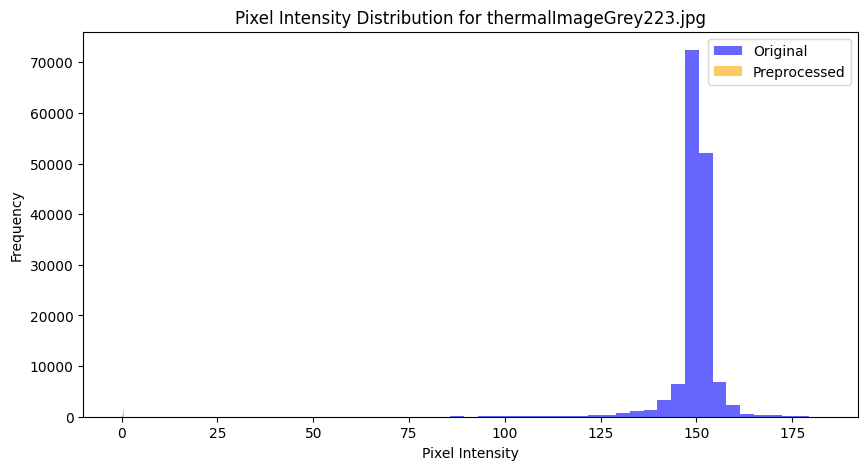

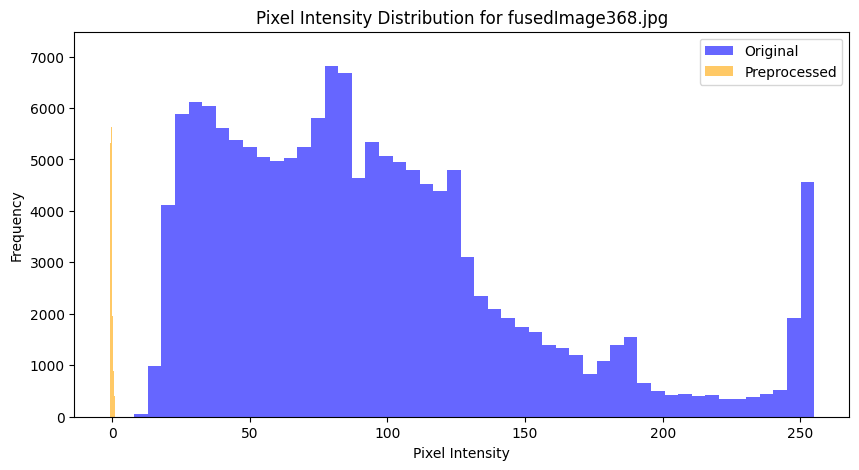

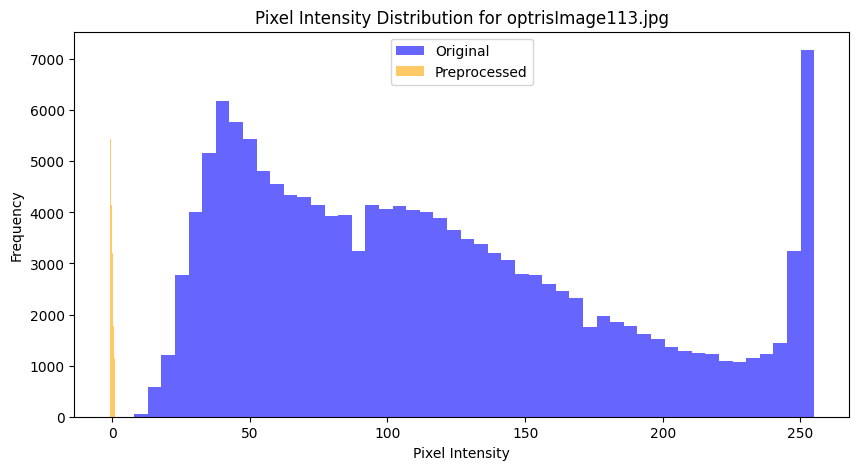

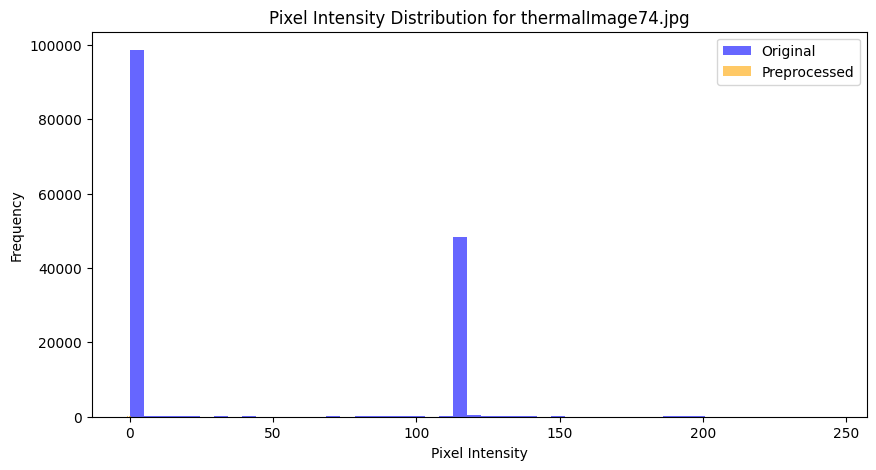

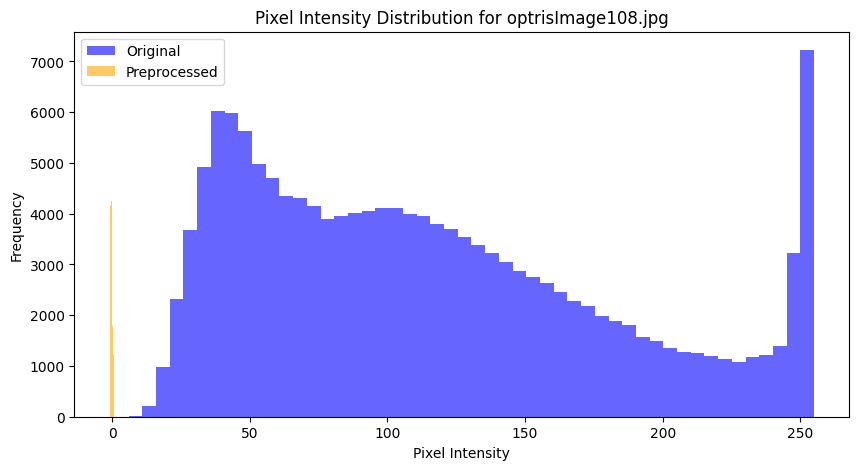

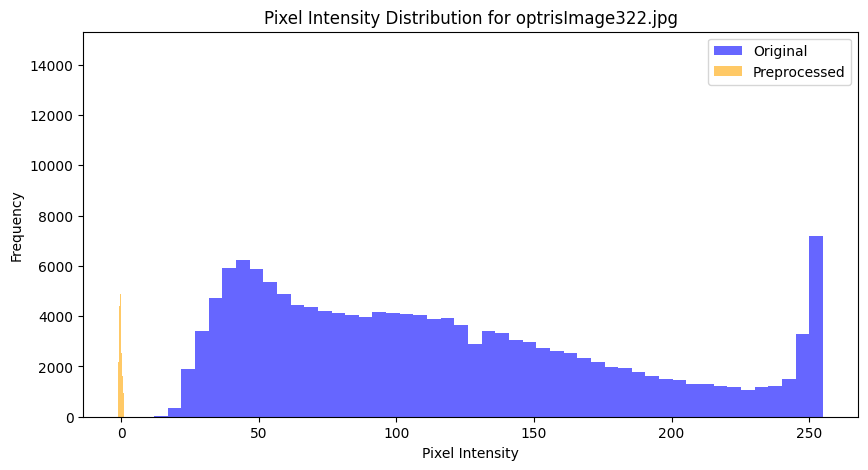

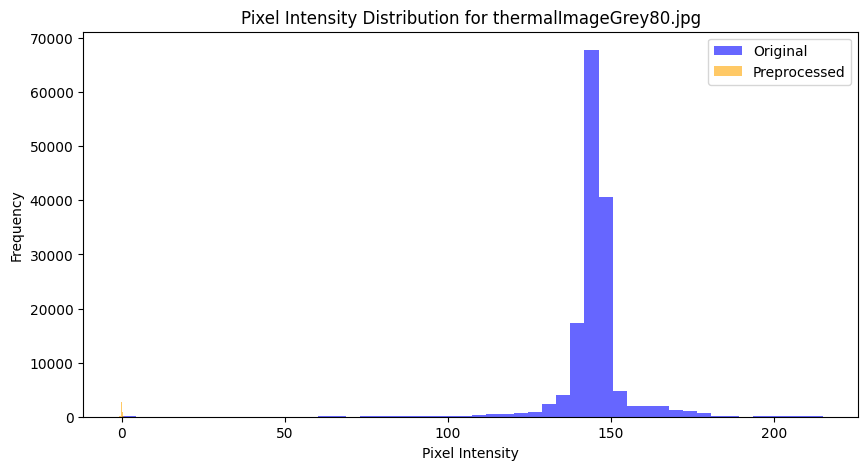

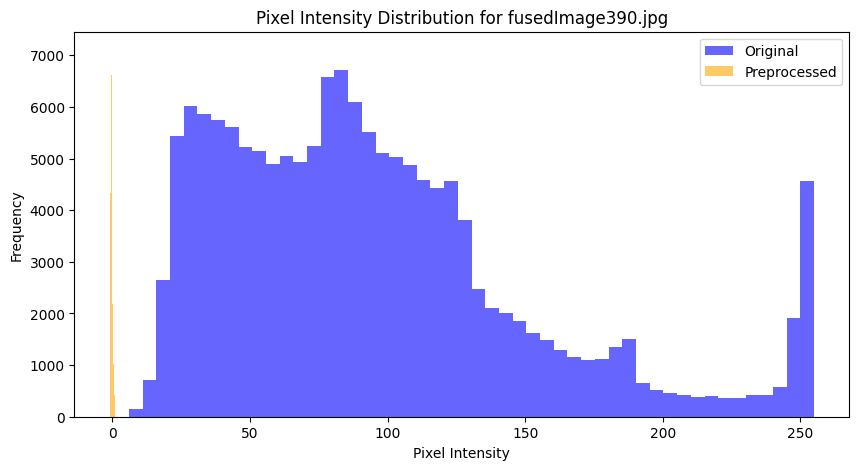

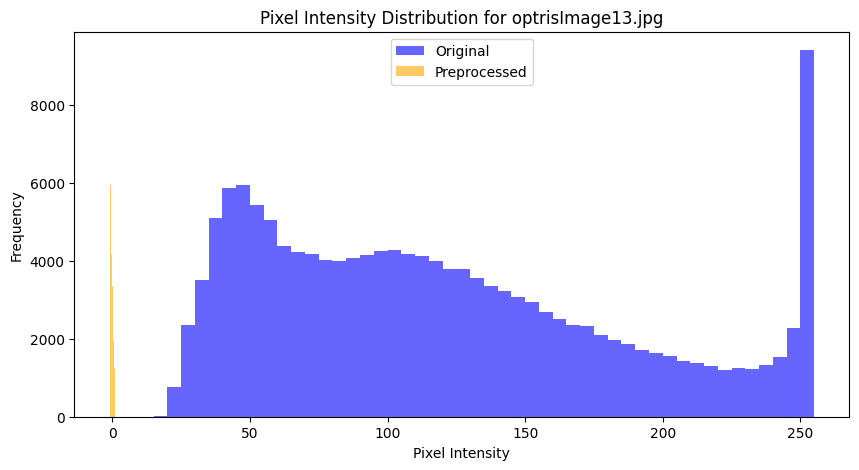

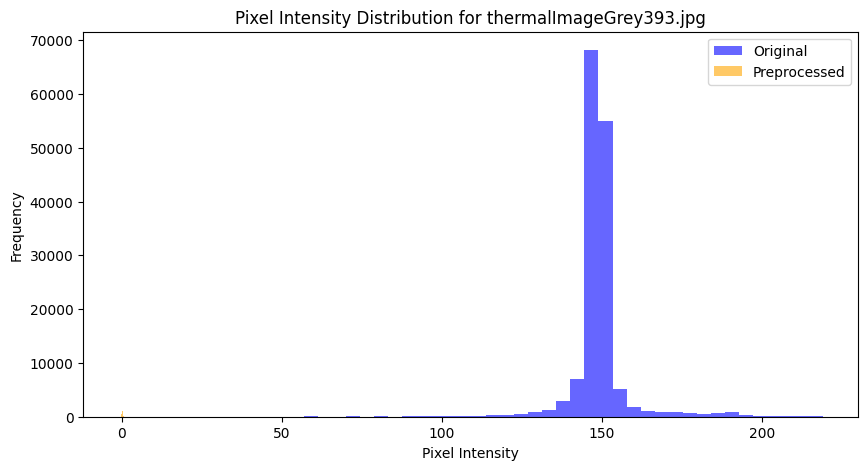

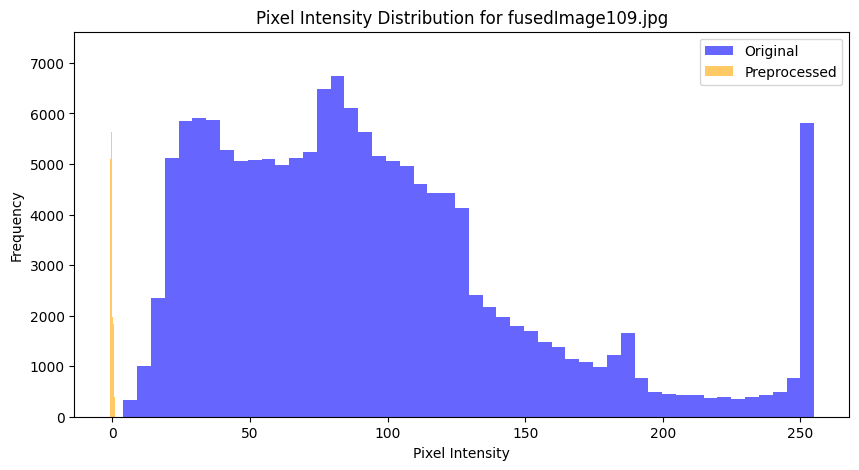

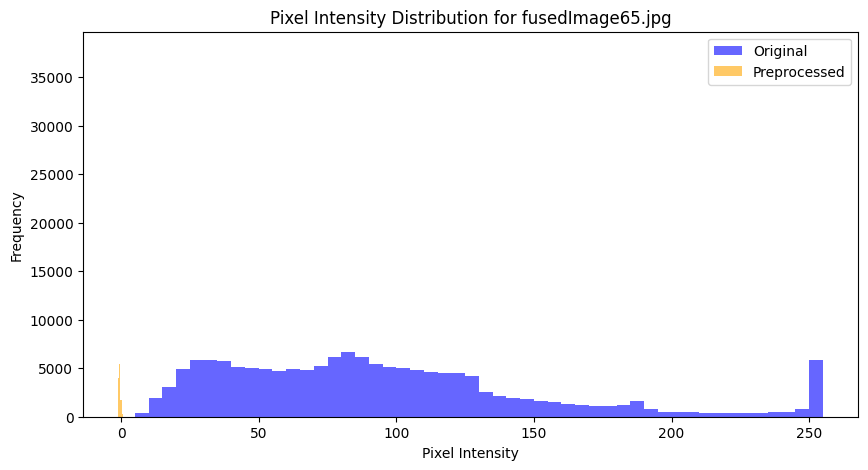

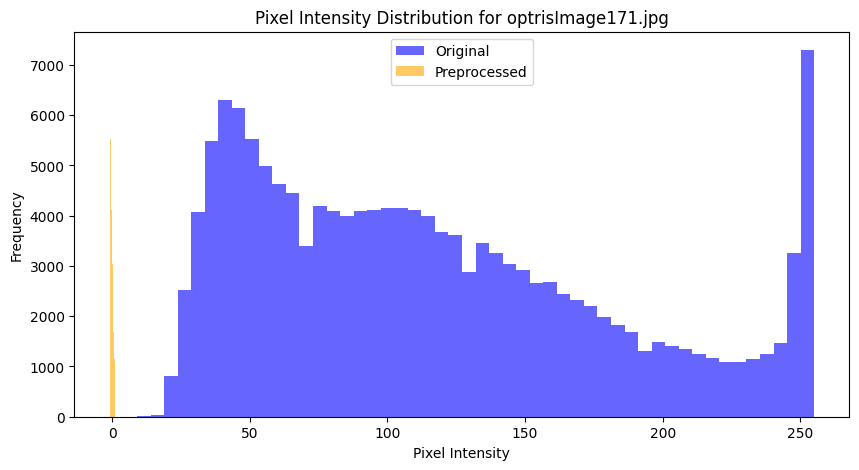

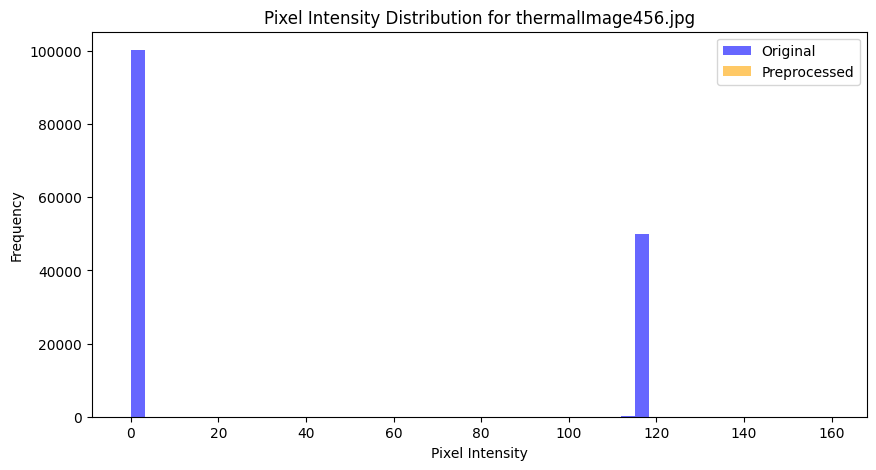

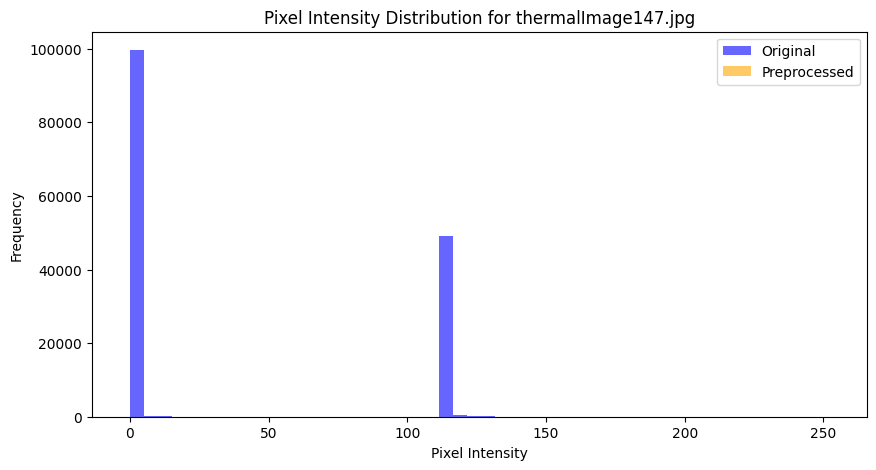

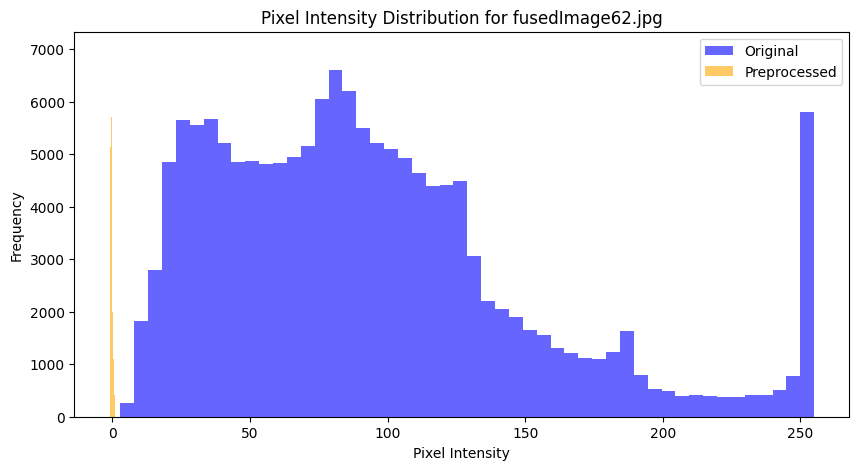

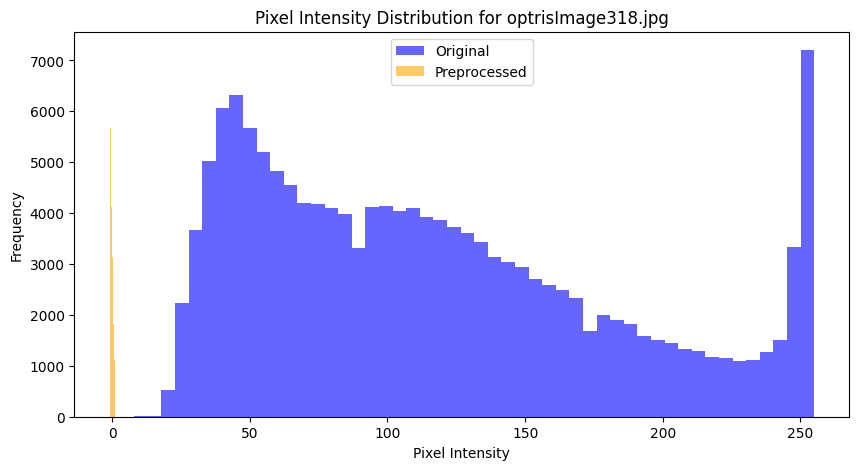

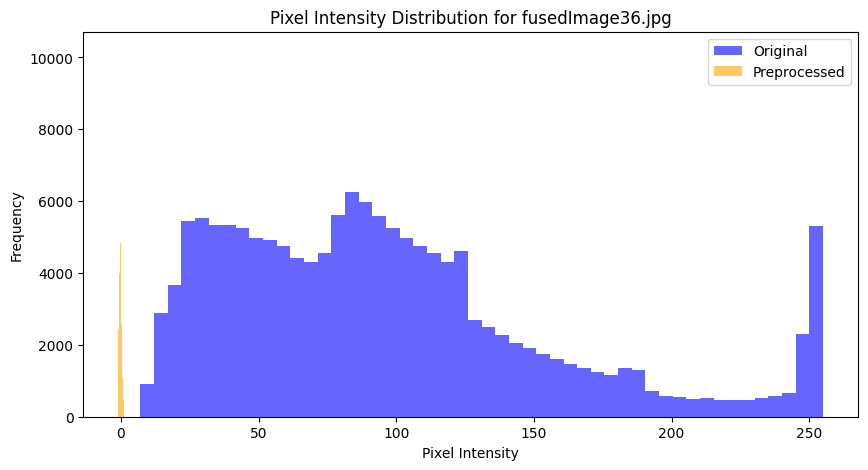

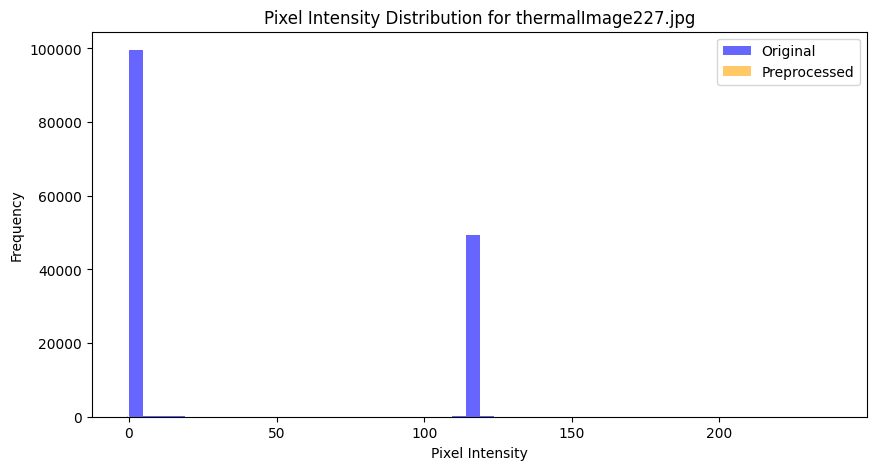

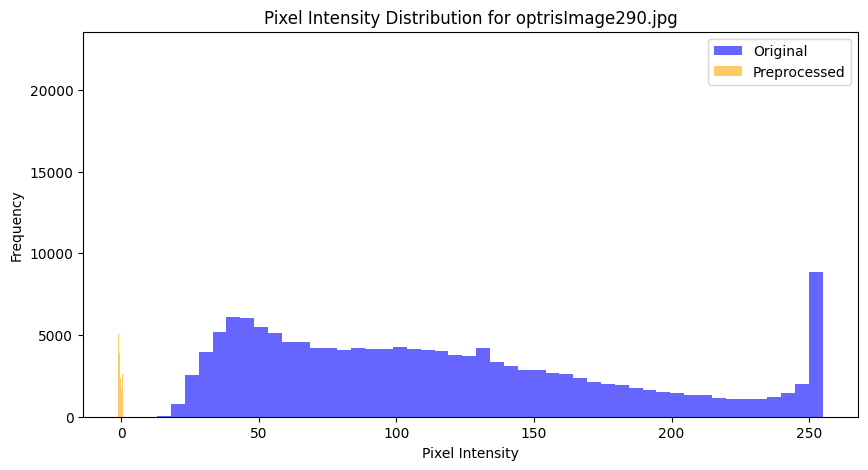

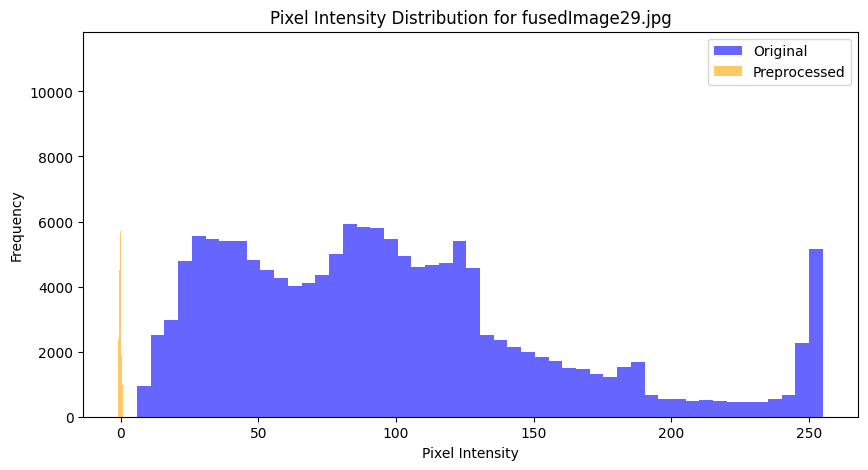

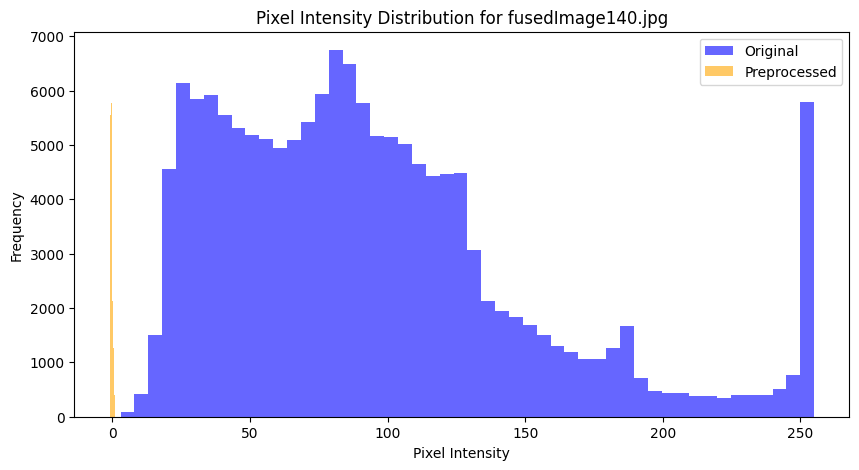

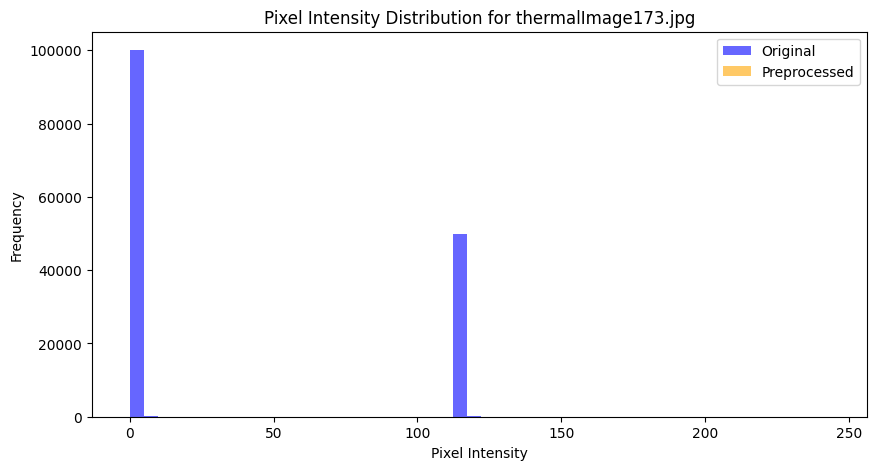

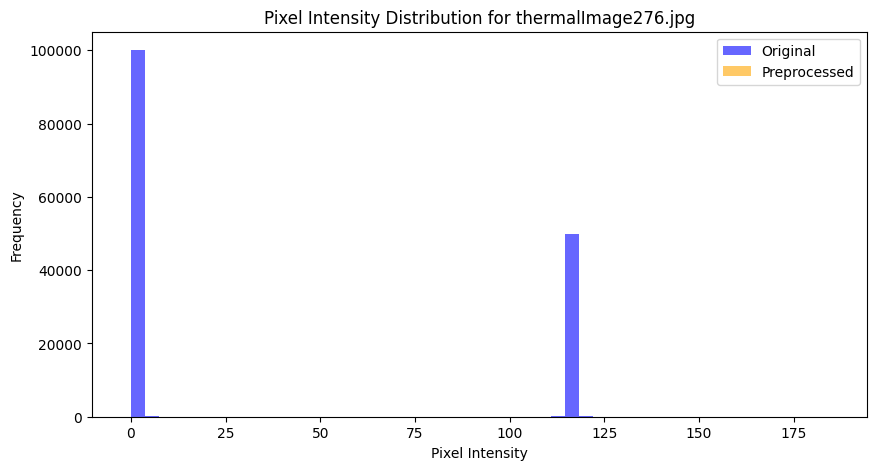

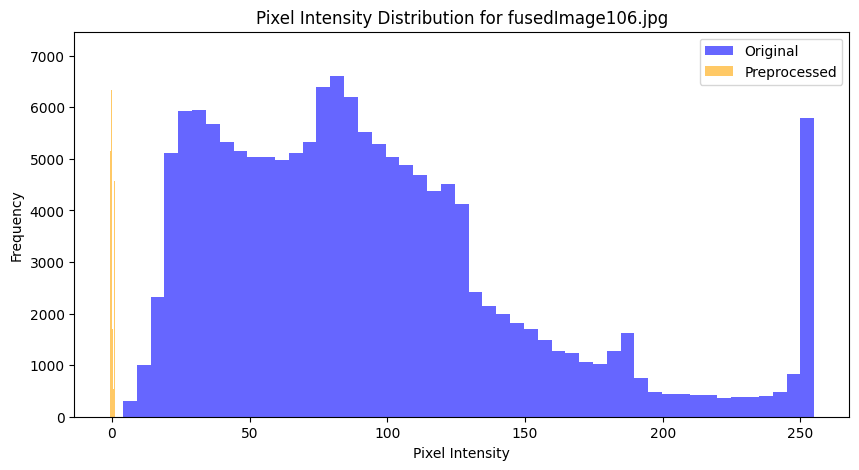

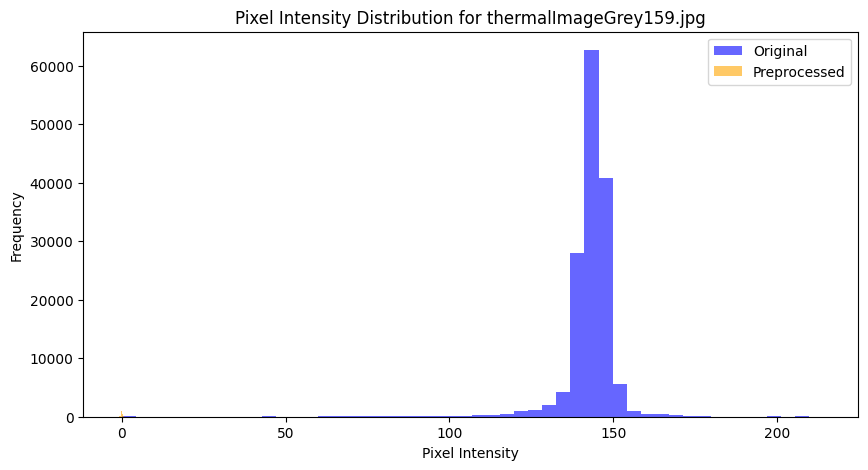

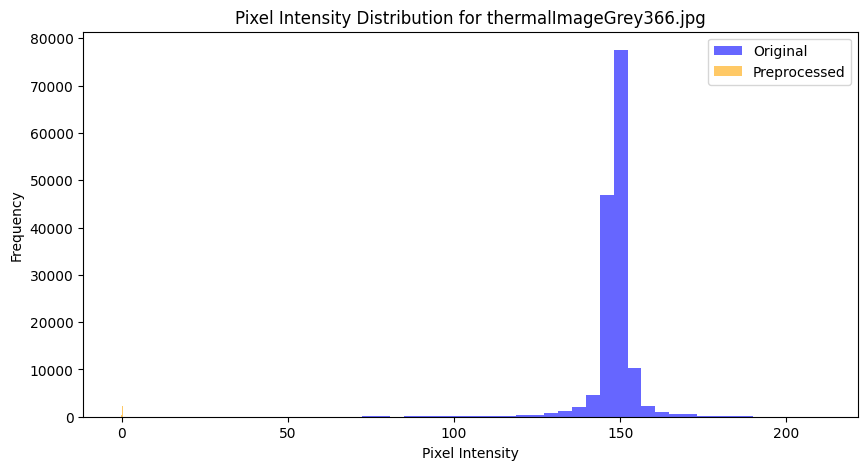

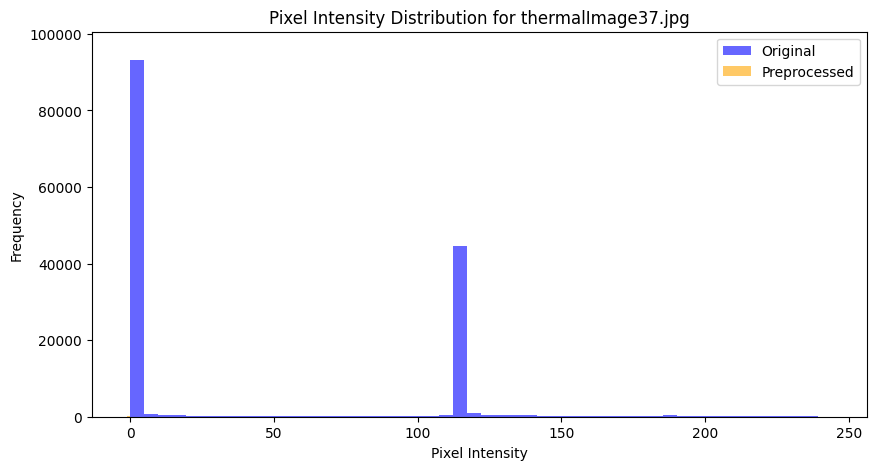

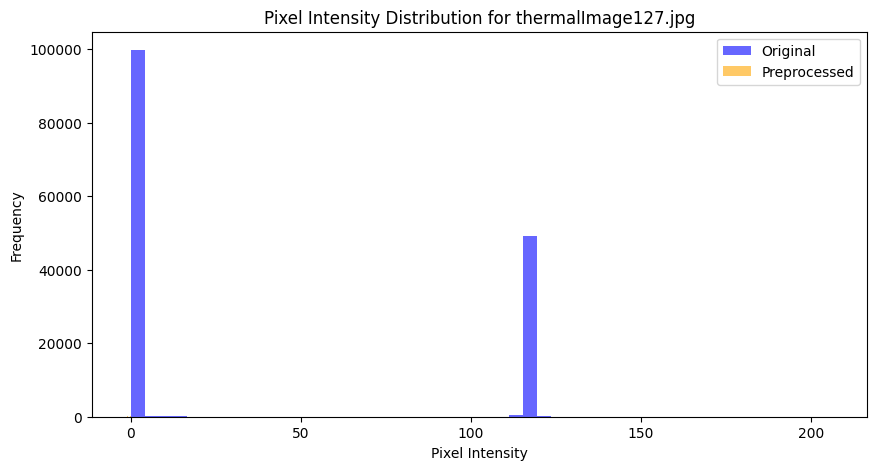

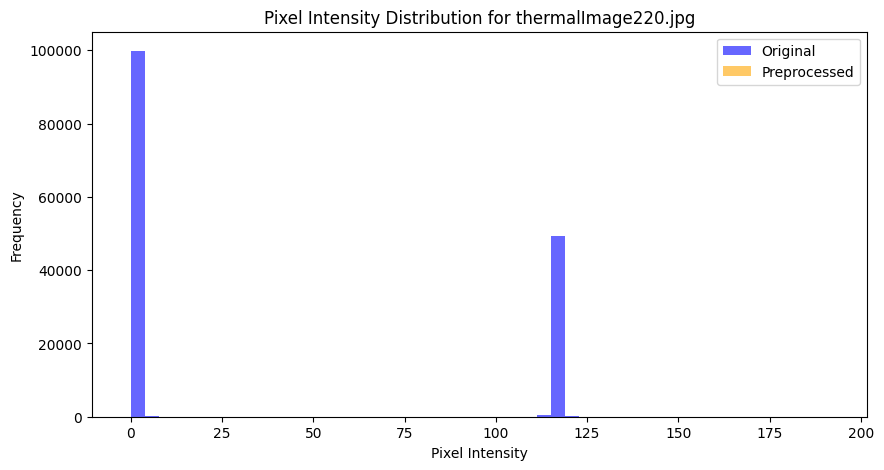

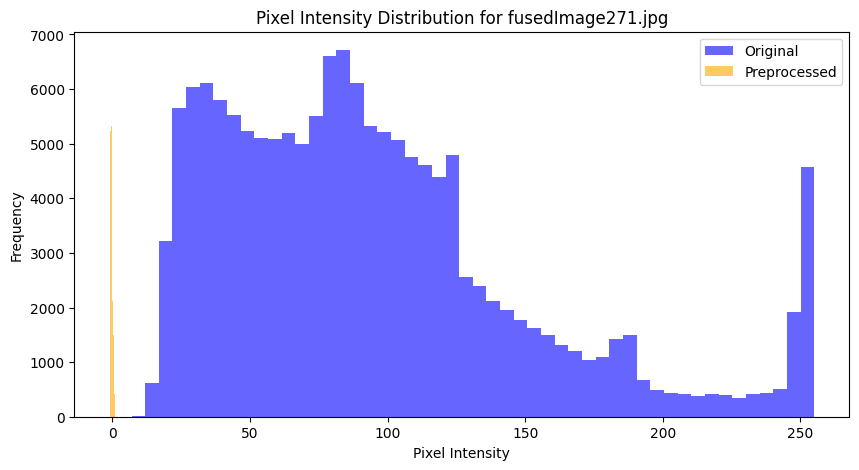

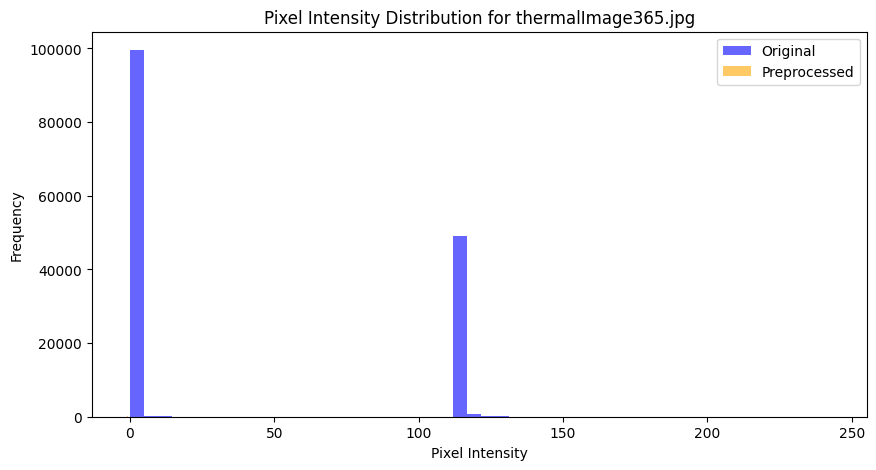

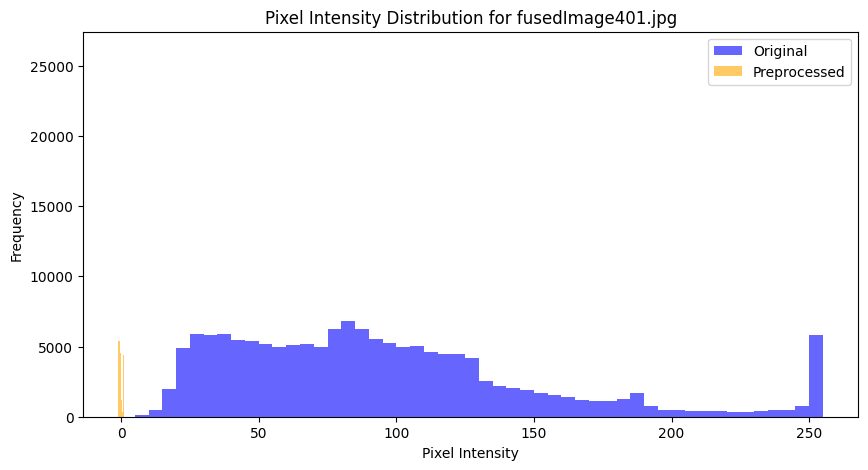

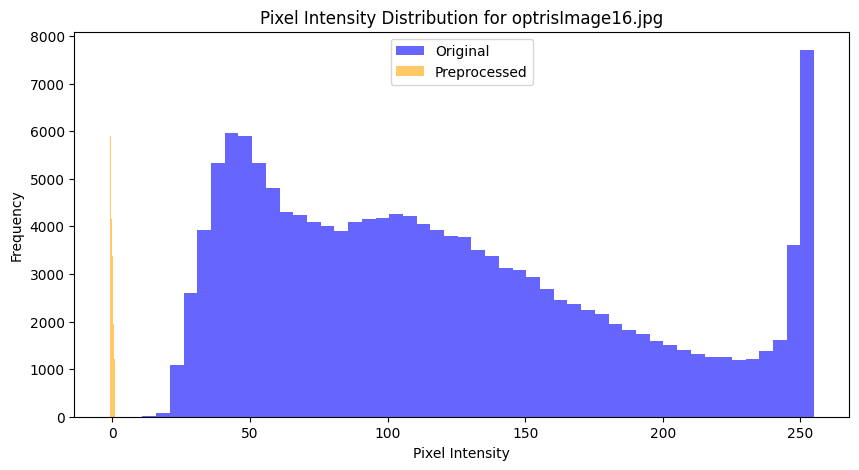

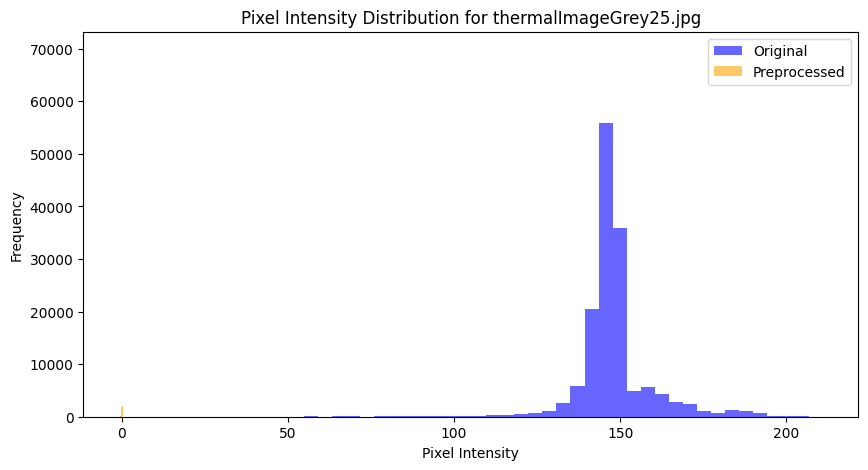

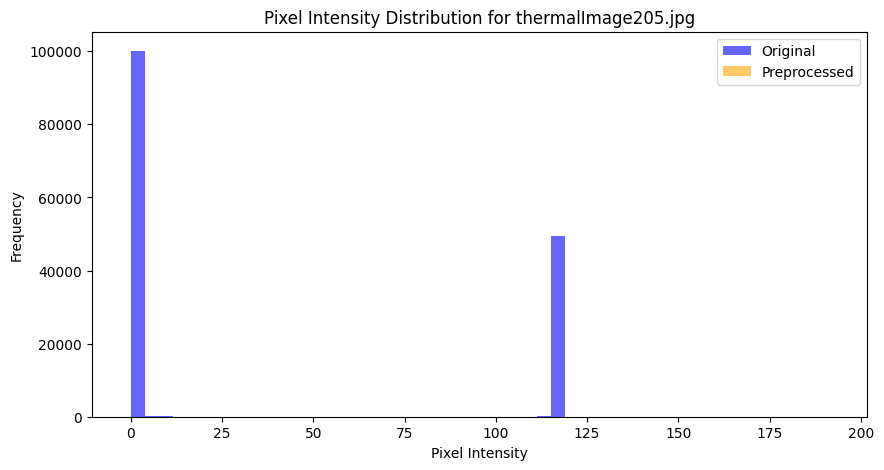

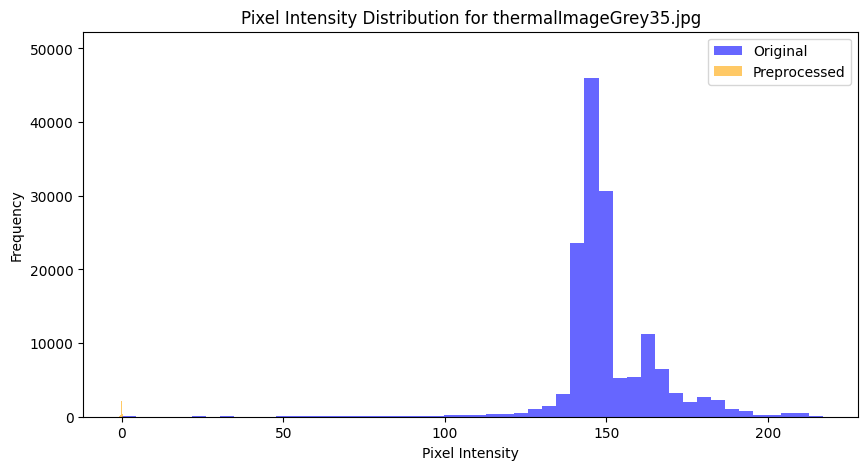

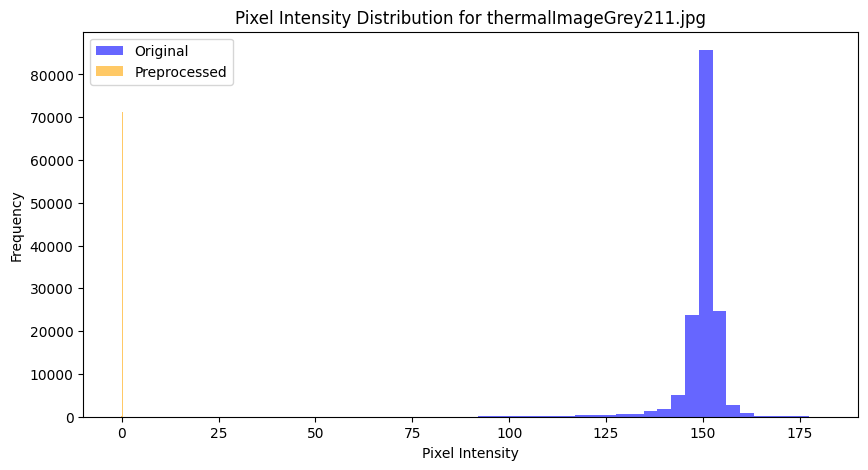

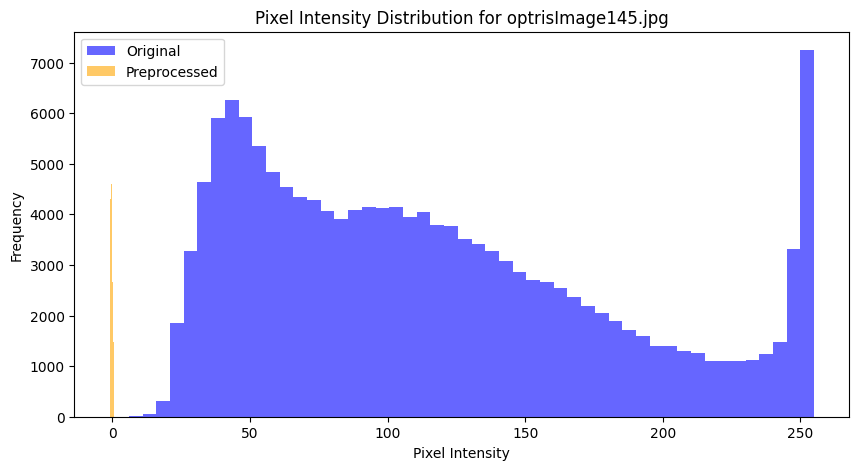

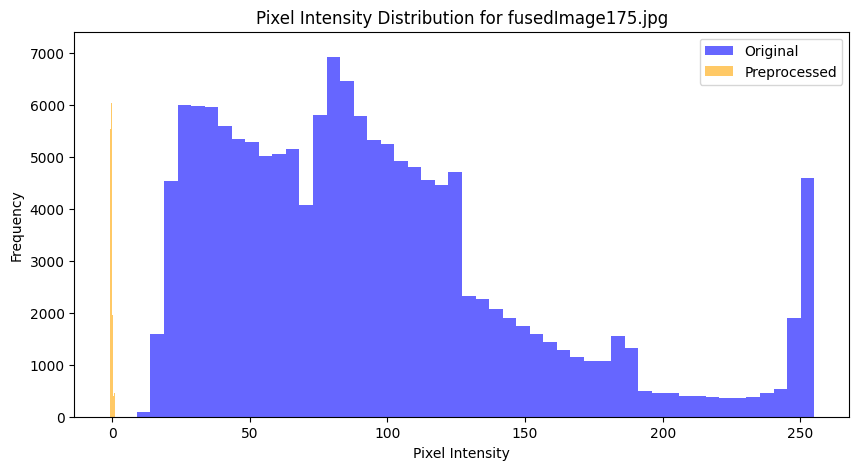

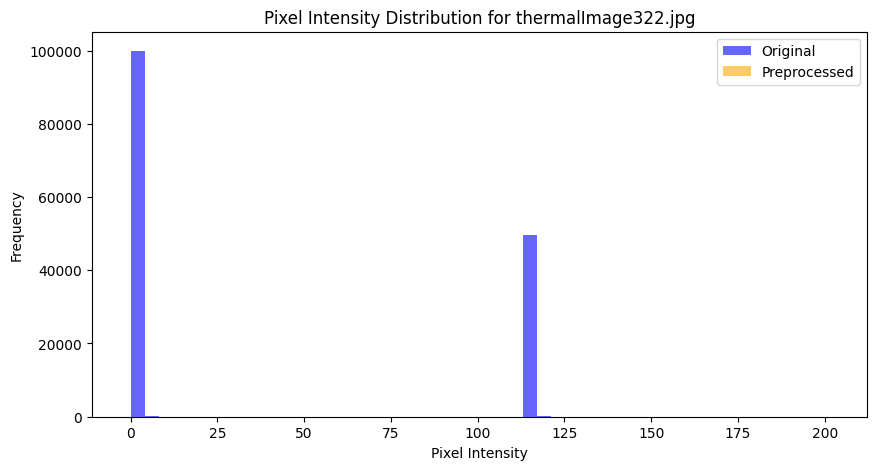

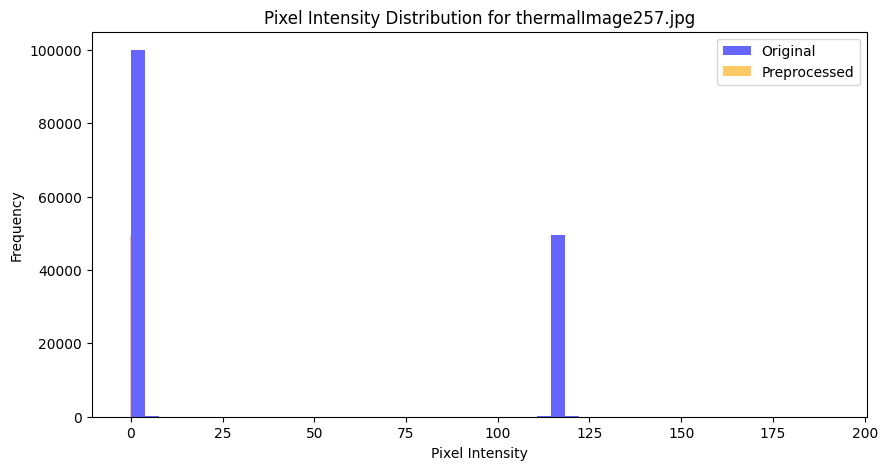

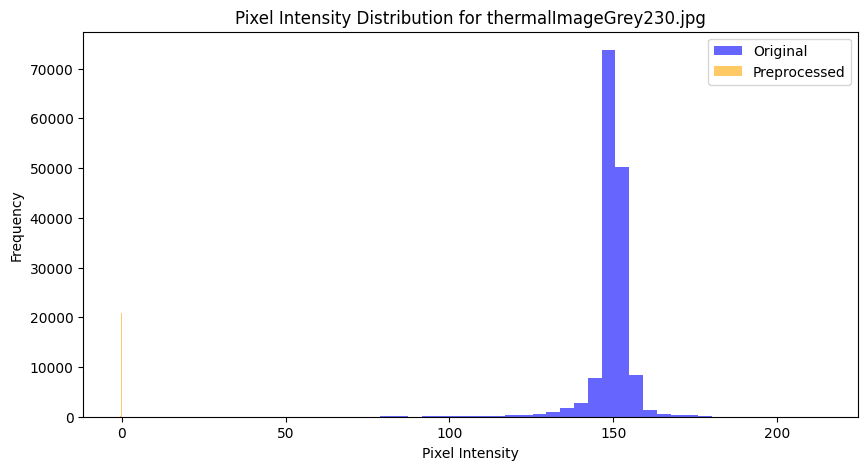

In [3]:
import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from albumentations import Compose, GaussianBlur, RandomBrightnessContrast, Resize, Normalize
from matplotlib import pyplot as plt

dataset_path = '/kaggle/input/ir-in-forestry-environments-aostovar/slu1_2014_06_24'
output_path = '/kaggle/working/preprocessed_images'
os.makedirs(output_path, exist_ok=True)

def preprocess_image(image):
    transform = Compose([
        GaussianBlur(blur_limit=(3, 7), p=0.5),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        Resize(224, 224),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    return transform(image=image)['image']


def load_and_preprocess_images(dataset_path, limit=10):
    images = []
    preprocessed_images = []
    titles = []

    for i, filename in enumerate(os.listdir(dataset_path)):
        if i >= limit:
            break
        img_path = os.path.join(dataset_path, filename)
        image = cv2.imread(img_path)

        if image is not None:
            # Resize the original image to 224x224
            resized_image = cv2.resize(image, (224, 224))
            images.append(resized_image)
            processed_image = preprocess_image(resized_image)
            preprocessed_images.append(processed_image)
            titles.append(filename)
            
            processed_image_path = os.path.join(output_path, f"processed_{filename}")
            cv2.imwrite(processed_image_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))     

    return images, preprocessed_images, titles

# Calculate PSNR and SSIM metrics
def calculate_metrics(original, processed):
    psnr_value = psnr(original, processed, data_range=processed.max() - processed.min())
    ssim_value = ssim(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY), 
                      data_range=processed.max() - processed.min())
    return psnr_value, ssim_value

# Analyze images and calculate metrics
def analyze_images(images, preprocessed_images, titles):
    psnr_values = []
    ssim_values = []

    for i in range(len(images)):
        psnr_value, ssim_value = calculate_metrics(images[i], preprocessed_images[i])
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
        print(f"{titles[i]} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")

    return psnr_values, ssim_values

def plot_pixel_intensity_subplots(images, preprocessed_images, titles, max_images=10):
    num_images = min(len(images), max_images)  # Limit to the first 'max_images' images
    rows, cols = 5, 2  # Arrange in 5x2 grid for 10 images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
    fig.suptitle("Pixel Intensity Distribution of Original vs Preprocessed Images", fontsize=16)
    
    for i in range(num_images):
        original = images[i].flatten()
        processed = preprocessed_images[i].flatten()
        row, col = divmod(i, cols)

        # Plot on the appropriate subplot
        ax = axes[row, col]
        ax.hist(original, bins=50, color='blue', alpha=0.6, label='Original')
        ax.hist(processed, bins=50, color='orange', alpha=0.6, label='Preprocessed')
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{titles[i]}')
        ax.legend()

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
    plt.show()
# Main function
if __name__ == "__main__":
    images, preprocessed_images, titles = load_and_preprocess_images(dataset_path, limit=100)
    psnr_values, ssim_values = analyze_images(images, preprocessed_images, titles)
    
    plot_pixel_intensity_subplots(images, preprocessed_images, titles, max_images=10)
